In [171]:
import pandas as pd
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import time
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
sns.set(style='whitegrid',palette='pastel')
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
# !pip install nltk

In [124]:
df=pd.read_csv('merged_final_07172019.csv',thousands=',')

In [125]:
df=df.drop(columns=['raised','goal'])

In [126]:
df.head(3)

,Unnamed: 0,link,location,summary,title,created_date,tag,state,goal_int,raised_int
0,0,https://www.gofundme.com/steven-crowder-live-a...,"Dallas, TX",SMU College Republicans is bringing comedian S...,Steven Crowder Live at SMU!,"Created March 7, 2018",rep,TX,6500.0,2710.0
1,1,https://www.gofundme.com/reopen-a-nc-republica...,"Brookline, MA",NOTE: We reached our goal and then some in les...,Dems help reopen a NC Repub office,"Created October 16, 2016",rep,MA,10000.0,12857.0
2,2,https://www.gofundme.com/troopersanchez,"Mcallen, TX","￼ Moises Sanchez, a Texas State Trooper, was s...",Funds for Trooper Moises Sanchez,"Created April 7, 2019",rep,TX,20000.0,13021.0


In [127]:
#getting a look at how many campaigns with word "democrat" vs "republican"
df.tag.value_counts()

rep    864
dem    850
Name: tag, dtype: int64

In [128]:
#overlap count
df.link.value_counts()[df.link.value_counts()==2].count()

254

In [129]:
#converting dates
df['created_date']=df.created_date.str.replace('Created ','')

# df['date']=pd.to_datetime(df.created_date,infer_datetime_format=True)

In [130]:
#you'll have to drop the 1 day ago, 3 days ago...
ago_df=df[df.created_date.str.contains('ago')==True]
ago_df['created_date']=ago_df.created_date.str.replace(' ago','')

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
ago_df.head(3)

,Unnamed: 0,link,location,summary,title,created_date,tag,state,goal_int,raised_int
467,531,https://www.gofundme.com/defeat-the-hijackers-...,"Grand Blanc, MI",For the last seven years I have been the subje...,"Hijacking America: The Book, ExplCmte Joe4Prez",1 day,rep,MI,5000.0,51.0
670,765,https://www.gofundme.com/1planet-climate-champ...,"Alexandria, VA",The Republican Majority in the Virginia Genera...,1Planet Climate Champions Fund,6 days,rep,VA,3000.0,100.0
744,848,https://www.gofundme.com/AMassiveParadigmShift,"Boston, MA",The September 11th Attacks... put America on a...,HELP SAVE THE AMERICAN DREAM!,3 hours,rep,MA,50000000.0,0.0


In [132]:
# turn hours ago to 1 day ago
ago_df.loc[ago_df.created_date.str.contains("hour"), 'created_date']='1 day'

In [133]:
# extract the date difference
ago_df['data_diff'] = ago_df.created_date.str.extract(r'(\d+)', expand=False).astype(int)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [134]:
#since this data was grabbed 7/17 we'll have to subtract a few more days
ago_df['created_actual']=ago_df['data_diff'].apply(lambda x: pd.datetime.now().date()-timedelta(days=x+5))

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [135]:
ago_df=ago_df.drop(columns=['created_date','data_diff'])

In [136]:
ago_df=ago_df.rename(columns={'created_actual':'created_date'})

In [137]:
df=df[df.created_date.str.contains('ago')==False]

In [138]:
df=df.append(ago_df)

In [149]:
#convert to datetime and add Year, Month, Weekday
df['year']=pd.to_datetime(df.created_date).dt.year
df['month']=pd.to_datetime(df.created_date).dt.month
df['weekday_name'] =pd.to_datetime(df.created_date).dt.weekday_name

# Using Crosstab to Compare "Democrat" vs "Republican"

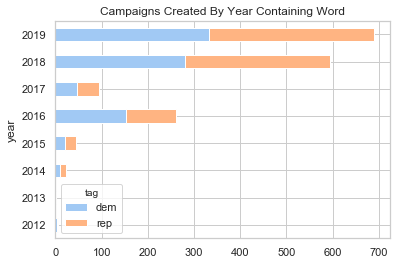

In [172]:
pd.crosstab(index=df.year,columns=df.tag).plot(kind='barh',stacked=True,title='Campaigns Created By Year Containing Word')

In [161]:
overlap=df[df.link.isin(df.link.value_counts()[df.link.value_counts()==2].index)]

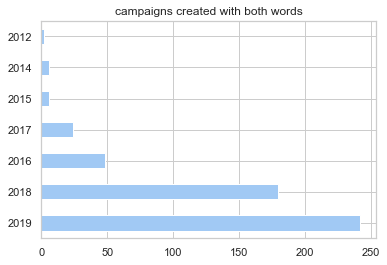

In [173]:
overlap.year.value_counts().plot(kind='barh',title='campaigns created with both words')

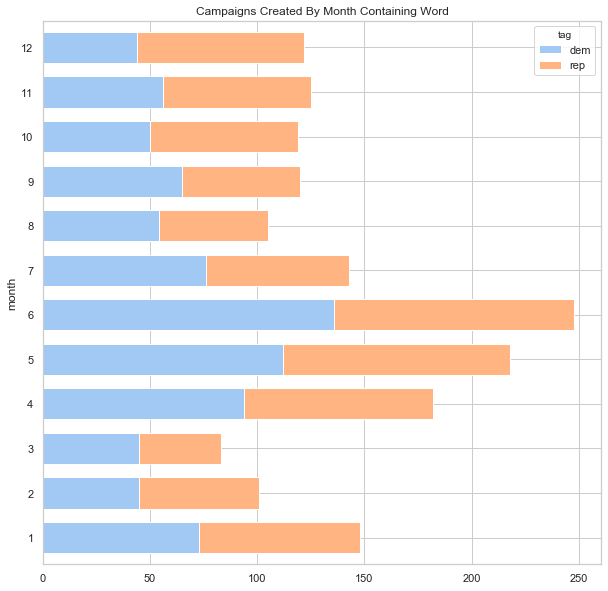

In [174]:
pd.crosstab(index=df.month,columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Month Containing Word',figsize=(10,10))

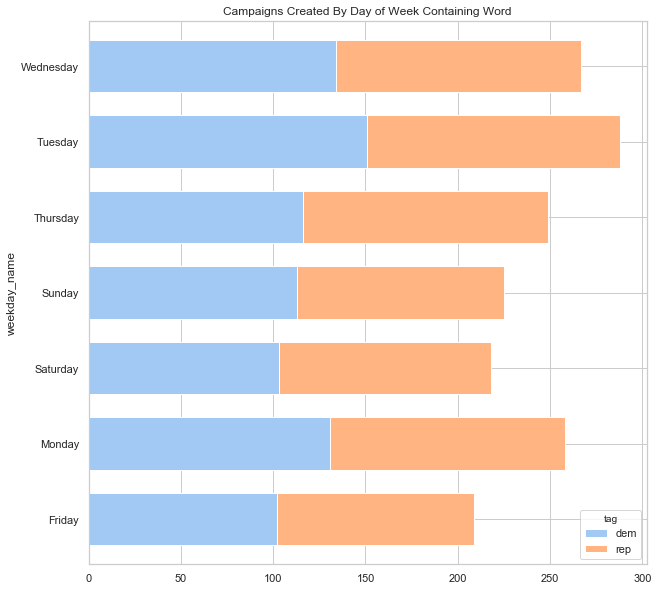

In [175]:
pd.crosstab(index=df['weekday_name'],columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Day of Week Containing Word',figsize=(10,10))

In [180]:
df.groupby('tag')['goal_int'].median()

tag
dem    5000.0
rep    9250.0
Name: goal_int, dtype: float64

In [181]:
overlap.goal_int.median()

10000.0

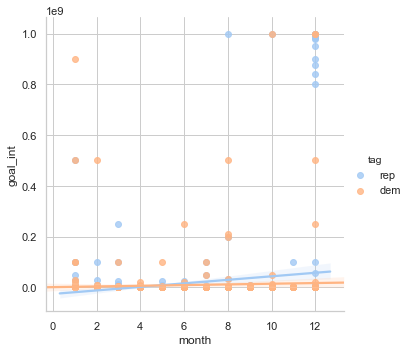

In [182]:
sns.lmplot(x='month',y='goal_int',hue='tag',data=df)

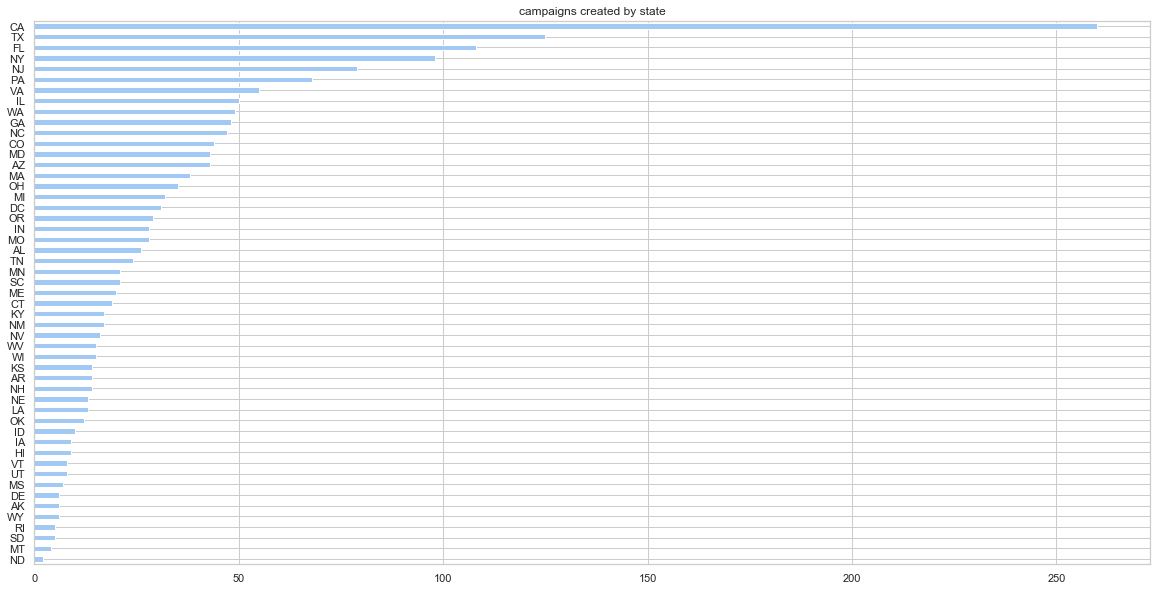

In [201]:
df.state.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(20,10),title='campaigns created by state')

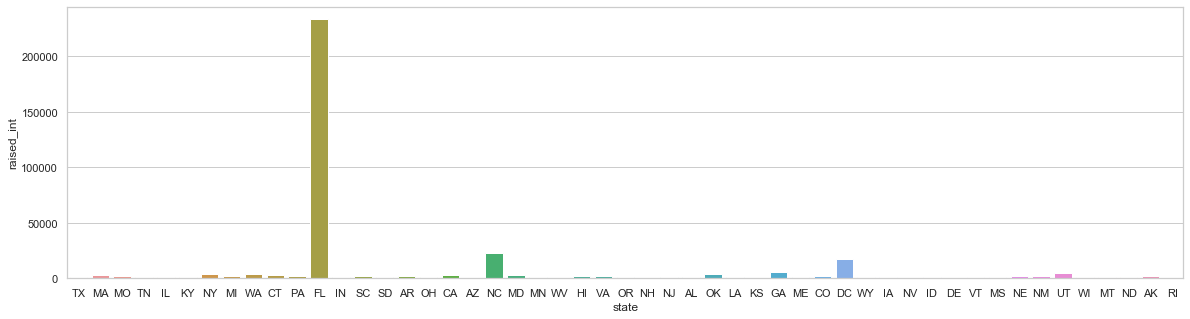

In [211]:
plt.figure(figsize=(20,5))
sns.barplot(x='state',y='raised_int',ci=0,data=df)

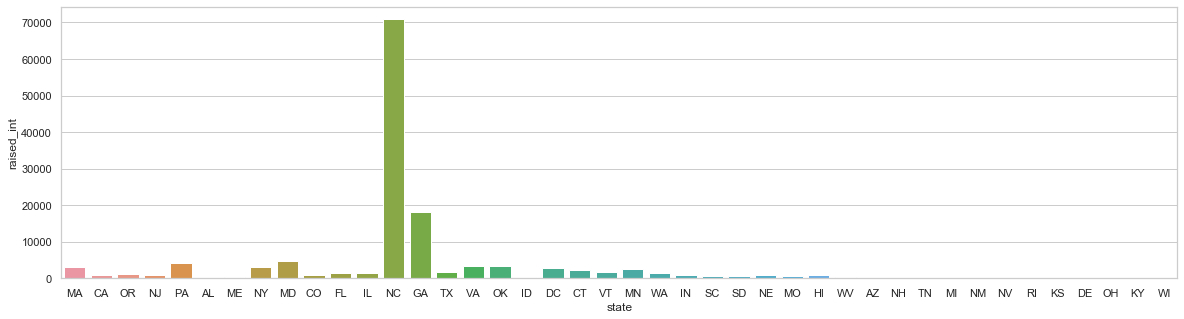

In [208]:
plt.figure(figsize=(20,5))
sns.barplot(x='state',y='raised_int',ci=0,data=overlap)

# Aggregate Graphs


In [249]:
# #using seaborn time series formatting
# sns.set(rc={'figure.figsize':(11, 4)})

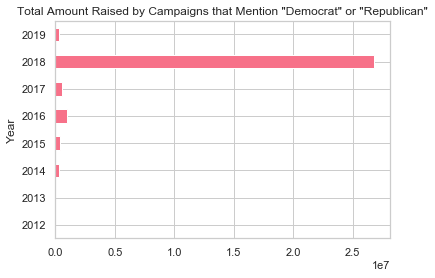

In [253]:
#total amount raised
#what is this scale though? How do I change this?
df.groupby('Year')['raised_int'].sum().plot(kind='barh',title='Total Amount Raised by Campaigns that Mention "Democrat" or "Republican"')

# plt.savefig("total_amount_raised.pdf")

In [254]:
data=pd.DataFrame(df.groupby('Year')['tag'].value_counts())

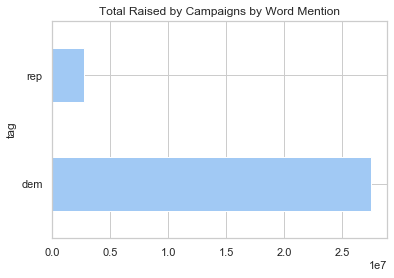

In [203]:
df.groupby('tag')['raised_int'].sum().plot(kind='barh',title='Total Raised by Campaigns by Word Mention')

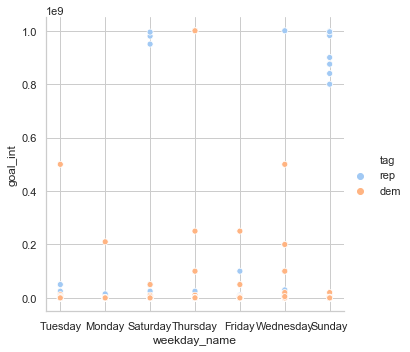

In [213]:
#the graveyard

graveyard = df[df['raised_int']==0]
sns.relplot(data=graveyard, x='weekday_name', y='goal_int', hue='tag')

# Common Words!

In [232]:
#campaigns with the word republican
top_N = 100000
rep_rslt =pd.DataFrame()
for index, row in df[df['tag']=='rep'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    rep_rslt=rep_rslt.append(rslt)

All frequencies, including STOPWORDS:
             Word  Frequency
0             smu          4
1              to          4
2               ,          3
3         crowder          2
4              on          2
5              at          2
6        mcfarlin          2
7               .          2
8             the          2
9         college          1
10    republicans          1
11             is          1
12       bringing          1
13       comedian          1
14         steven          1
15       thursday          1
16          march          1
17             22          1
18            7pm          1
19             in          1
20     auditorium          1
21            due          1
22             an          1
23      extremely          1
24           high          1
25         demand          1
26            see          1
27         louder          1
28           with          1
29           live          1
30             we          1
31            are          1
32   

             Word  Frequency
0          truman          2
1              of          2
2               a          2
3           about          2
4               ,          2
5              to          2
6               .          2
7              we          2
8             the          1
9           young          1
10     republican          1
11              ’          1
12              s          1
13           club          1
14       consists          1
15          group          1
16             15          1
17    responsible          1
18      motivated          1
19           high          1
20         school          1
21       students          1
22            who          1
23           wish          1
24        educate          1
25     themselves          1
26            and          1
27         others          1
28        current          1
29      political          1
30         issues          1
31             as          1
32     first-year          1
33   organizat

           Word  Frequency
0            to          3
1             .          2
2           the          1
3          ucsc          1
4       college          1
5   republicans          1
6          want          1
7         bring          1
8           you          1
9       amazing          1
10     speakers          1
11          and          1
12       events          1
13          our          1
14       campus          1
15           we          1
16         need          1
17        money          1
18         make          1
19         this          1
20       happen          1
21       thanks          1
22          for          1
23         your          1
24     generous          1
25      support          1
26            !          1
All frequencies, including STOPWORDS:
             Word  Frequency
0             for          3
1             our          2
2               ,          2
3         katelyn          2
4             has          2
5     congressman          2
6  

           Word  Frequency
0           the          4
1             a          4
2            of          2
3          club          2
4         black          2
5             .          2
6             ’          2
7          name          2
8            to          2
9            we          2
10        group          2
11          our          2
12            i          1
13           am          1
14      founder          1
15           at          1
16           my          1
17       school          1
18       called          1
19   republican          1
20      leaders          1
21          don          1
22            t          1
23          let          1
24      confuse          1
25          you          1
26            ,          1
27     everyone          1
28           is          1
29      allowed          1
30       attend          1
31          but          1
32        chose          1
33      because          1
34           re          1
35        young          1
3

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          4
1             i          3
2             a          3
3            in          3
4            am          2
5           and          2
6           who          2
7            as          2
8           gay          2
9           man          1
10           of          1
11      african          1
12        mixed          1
13     american          1
14      descent          1
15   identifies          1
16       person          1
17     involved          1
18          m2m          1
19         some          1
20   categorize          1
21           it          1
22          but          1
23       rather          1
24          not          1
25           be          1
26  categorized          1
27           by          1
28  substandard          1
29         bias          1
30            .          1
31        black          1
32   republican          1
33        short          1
34     believes  

All frequencies, including STOPWORDS:
      Word  Frequency
0        a          3
1        .          3
2     just          2
3   family          2
4      not          1
5      gon          1
6       na          1
7     give          1
8      sob          1
9    story          1
10       i          1
11    need          1
12   money          1
13    want          1
14      to          1
15     buy          1
16    home          1
17     for          1
18      my          1
19     and          1
20   maybe          1
21    nice          1
22     van          1
23   bills          1
24    take          1
25      it          1
26     all          1
27     but          1
28    that          1
29      's          1
30    life          1
31  though          1
All frequencies, including STOPWORDS:
             Word  Frequency
0              we          5
1             the          3
2            have          3
3            club          2
4             and          2
5              us       

All frequencies, including STOPWORDS:
     Word  Frequency
0   whose          1
1  better          1
2       ?          1
All frequencies, including STOPWORDS:
          Word  Frequency
0           to          5
1          and          3
2           in          3
3            i          2
4      african          2
5            .          2
6            a          2
7            ,          2
8       bigger          2
9        would          1
10        like          1
11       bring          1
12   awareness          1
13     support          1
14  republican          1
15   americans          1
16    illinois          1
17      living          1
18        blue          1
19       state          1
20        also          1
21       being          1
22    american          1
23          my          1
24       views          1
25      issues          1
26         are          1
27       swept          1
28         the          1
29        side          1
30         for          1
31      

All frequencies, including STOPWORDS:
           Word  Frequency
0             a          3
1            to          3
2            us          3
3          very          2
4           who          2
5             .          2
6           are          2
7           and          2
8            we          2
9           not          2
10         have          2
11        being          1
12        young          1
13   republican          1
14           is          1
15    difficult          1
16   especially          1
17           in          1
18      country          1
19         with          1
20         many          1
21     libtards          1
22           so          1
23  desperately          1
24         want          1
25         shut          1
26  republicans          1
27           up          1
28          our          1
29        names          1
30        katie          1
31         sara          1
32            ,          1
33         come          1
34         from  

All frequencies, including STOPWORDS:
           Word  Frequency
0           the          6
1      students          3
2        school          2
3            17          2
4            to          2
5         after          1
6      massacre          1
7            at          1
8       marjory          1
9      stoneman          1
10      douglas          1
11         high          1
12           in          1
13     parkland          1
14      florida          1
15         that          1
16        kills          1
17          and          1
18      injured          1
19        other          1
20            ,          1
21       united          1
22       states          1
23   republican          1
24   leadership          1
25    committee          1
26           is          1
27       stands          1
28           up          1
29         help          1
30       boards          1
31       around          1
32      country          1
33      provide          1
34            a  

All frequencies, including STOPWORDS:
          Word  Frequency
0            a          4
1            i          3
2            .          3
3           my          3
4            ,          2
5          all          2
6           is          2
7      parents          2
8           of          2
9        hello          1
10    everyone          1
11        hope          1
12         you          1
13         are          1
14      having          1
15     blessed          1
16         day          1
17        name          1
18     melanie          1
19         and          1
20    recently          1
21        have          1
22        been          1
23  struggling          1
24       guess          1
25          it          1
26       began          1
27        when          1
28     married          1
29         man          1
30       named          1
31   johnathan          1
32       while          1
33      living          1
34          as          1
35     student          1


         Word  Frequency
0           i          5
1           .          4
2         and          3
3           ,          2
4          my          2
5           a          2
6       trump          2
7         the          2
8         for          2
9        time          2
10         hi          1
11       name          1
12         is          1
13       andy          1
14         'm          1
15         21          1
16       year          1
17        old          1
18        gay          1
19  supporter          1
20   recently          1
21    parents          1
22     kicked          1
23         me          1
24        out          1
25         of          1
26      house          1
27    because          1
28       told          1
29       them          1
30       that          1
31    support          1
32       need          1
33       help          1
34         to          1
35        pay          1
36         an          1
37  apartment          1
38       rent          1


               Word  Frequency
0                to          5
1                 i          3
2               the          3
3               and          2
4               for          2
5         candidate          2
6                 (          2
7                 r          2
8                 )          2
9                 .          2
10               am          1
11           hoping          1
12            raise          1
13           enough          1
14              get          1
15             over          1
16            texas          1
17            knock          1
18               on          1
19            doors          1
20           senate          1
21              ted          1
22             cruz          1
23            house          1
24               of          1
25  representatives          1
26             john          1
27        culberson          1
28             want          1
29             help          1
30                ’          1
31      

           Word  Frequency
0             i          3
1            of          3
2            to          3
3            my          2
4          like          2
5        myself          2
6             .          2
7            be          2
8            in          2
9            at          1
10  institution          1
11            ,          1
12         have          1
13         seen          1
14            a          1
15     profound          1
16       amount          1
17         hate          1
18        young          1
19  republicans          1
20         want          1
21         beat          1
22          the          1
23         odds          1
24          and          1
25         able          1
26         make          1
27    something          1
28        would          1
29  financially          1
30      support          1
31       fellow          1
32         club          1
33      members          1
34          our          1
35       unpaid          1
3

                          Word  Frequency
0                          the          4
1                            a          3
2                           of          2
3                         club          2
4                           we          2
5                           to          2
6                           on          2
7                          any          2
8                            .          2
9                           is          2
10                           i          1
11                          am          1
12                   president          1
13                        cape          1
14                        fear          1
15                   community          1
16                     college          1
17                 republicans          1
18                         and          1
19                         are          1
20                      trying          1
21                         get          1
22                        kick    

            Word  Frequency
0             to          4
1             we          3
2              ,          3
3         donate          3
4            you          3
5            the          2
6             of          2
7              .          2
8              $          2
9              5          2
10           are          1
11       uniting          1
12         thank          1
13         susan          1
14       collins          1
15           for          1
16           her          1
17    principled          1
18         stand          1
19       against          1
20  intimidation          1
21       threats          1
22           and          1
23    outrageous          1
24      thuggery          1
25           mob          1
26       leftist          1
27    ideologues          1
28        please          1
29         today          1
30             !          1
31          need          1
32           now          1
33             (          1
34            if    

            Word  Frequency
0            and          3
1       everyone          2
2              i          2
3              ’          2
4        started          2
5           that          2
6             to          2
7            our          2
8            for          2
9             my          2
10             a          1
11        letter          1
12          from          1
13         scott          1
14          anne          1
15             :          1
16            hi          1
17             !          1
18            ve          1
19       writing          1
20          over          1
21       several          1
22         times          1
23             ,          1
24           but          1
25             m          1
26     realizing          1
27            no          1
28         words          1
29          will          1
30            be          1
31      adequate          1
32       express          1
33  appreciation          1
34          what    

            Word  Frequency
0              a          3
1            and          3
2          flynn          2
3       children          2
4              .          2
5            the          2
6             of          2
7       american          1
8        patriot          1
9           mike          1
10        passed          1
11          away          1
12          june          1
13          23rd          1
14  unexpectedly          1
15          from          1
16         heart          1
17        attack          1
18             ,          1
19       leaving          1
20        behind          1
21          wife          1
22          four          1
23        please          1
24      consider          1
25  contribution          1
26            to          1
27        assist          1
28          with          1
29     education          1
30      expenses          1
31           for          1
32           was          1
33           one          1
34      original    

            Word  Frequency
0            you          4
1           this          3
2             if          2
3           then          2
4           live          2
5             in          2
6    connecticut          2
7              .          2
8              ,          2
9              :          2
10           the          2
11      governor          2
12           has          2
13            to          2
14          hate          1
15          face          1
16       already          1
17          know          1
18        really          1
19       screwed          1
20         place          1
21            up          1
22           one          1
23         thing          1
24          that          1
25        brings          1
26   republicans          1
27     democrats          1
28           and          1
29  independents          1
30      together          1
31            is          1
32         their          1
33        belief          1
34           got    

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          5
1           the          4
2     homestead          4
3             a          3
4          what          2
5            is          2
6          1812          2
7           and          2
8            of          2
9             ?          1
10      located          1
11           in          1
12    willsboro          1
13          new          1
14         york          1
15       museum          1
16  educational          1
17   foundation          1
18       living          1
19      history          1
20         farm          1
21        which          1
22     occupies          1
23          130          1
24        acres          1
25         land          1
26         near          1
27         long          1
28         pond          1
29           at          1
30         site          1
31          was          1
32         19th          1
33      century          1
34          inn  

                Word  Frequency
0                  .          3
1                  i          3
2                  a          3
3                  ,          2
4                 in          2
5                 to          2
6                the          2
7                 my          1
8               name          1
9                 is          1
10          dorianne          1
11  dias-koonopakarn          1
12                am          1
13                an          1
14          educator          1
15              wife          1
16         bi-racial          1
17          marriage          1
18               and          1
19            mother          1
20              four          1
21         brilliant          1
22          children          1
23              have          1
24     extraordinary          1
25             honor          1
26         represent          1
27          arkansas          1
28      progressives          1
29                as          1
30      

             Word  Frequency
0             the          5
1               ,          5
2              in          3
3           equal          2
4              as          2
5              is          2
6        equality          2
7               .          2
8             our          2
9           means          1
10            and          1
11   constitution          1
12    interpreted          1
13             by          1
14        supreme          1
15          court          1
16       ultimate          1
17      guarantor          1
18             of          1
19         united          1
20         states          1
21  unfortunately          1
22           even          1
23          today          1
24           very          1
25         modern          1
26        society          1
27         gender          1
28      protected          1
29           only          1
30            for          1
31          women          1
32             's          1
33         vot

All frequencies, including STOPWORDS:
           Word  Frequency
0       lincoln          2
1        county          2
2           the          2
3          this          2
4             .          2
5             ,          2
6         their          2
7   indivisible          1
8            is          1
9       running          1
10       second          1
11           of          1
12          our          1
13        three          1
14    full-page          1
15        issue          1
16          ads          1
17           in          1
18         week          1
19           's          1
20         news          1
21        aimed          1
22           at          1
23      pushing          1
24      turnout          1
25        among          1
26   undecideds          1
27          and          1
28    moderates          1
29           ad          1
30      reminds          1
31       reader          1
32         that          1
33  republicans          1
34          are  

               Word  Frequency
0                to          3
1                my          2
2                 i          2
3                'm          2
4          congress          2
5              time          2
6               the          2
7            fellow          1
8        floridians          1
9                 ,          1
10             name          1
11               is          1
12             kirk          1
13            troen          1
14              and          1
15          running          1
16              for          1
17               in          1
18          florida          1
19               's          1
20         district          1
21              10.          1
22            doing          1
23             best          1
24            bring          1
25             some          1
26           common          1
27            sense          1
28                .          1
29              our          1
30          elected          1
31  repr

          Word  Frequency
0         your          7
1            .          5
2          you          4
3            ,          3
4         body          2
5        still          2
6          and          2
7           ca          2
8          n't          2
9      imagine          1
10       being          1
11     trapped          1
12      inside          1
13         own          1
14        mind          1
15          is          1
16       sound          1
17        eyes          1
18        ears          1
19    function          1
20         but          1
21        from          1
22        nose          1
23        down          1
24          no          1
25      longer          1
26     control          1
27       speak          1
28        move          1
29        arms          1
30          or          1
31        legs          1
32         are          1
33      unable          1
34          to          1
35          do          1
36    anything          1
37         f

          Word  Frequency
0       voting          3
1       rights          3
2           to          3
3      restore          2
4            ,          2
5      florida          2
6          and          2
7          are          2
8     ex-felon          1
9        elect          1
10          's          1
11       first          1
12         poc          1
13    governor          1
14       swing          1
15         the          1
16        u.s.          1
17      senate          1
18           !          1
19          we          1
20       going          1
21    campaign          1
22         for          1
23      racial          1
24     justice          1
25           .          1
26        with          1
27        your          1
28     support          1
29         our          1
30           4          1
31    seasoned          1
32   activists          1
33        from          1
34         out          1
35          of          1
36       state          1
37     joini

          Word  Frequency
0          and          8
1          for          4
2        party          3
3    candidate          3
4       gloria          2
5           la          2
6         riva          2
7        peace          2
8      freedom          2
9     governor          2
10           ,          2
11           —          1
12        2018          1
13          is          1
14           a          1
15     veteran          1
16      social          1
17     justice          1
18    anti-war          1
19       union          1
20    activist          1
21   organizer          1
22           .          1
23         she          1
24         was          1
25        2010          1
26        2014          1
27        2016          1
28   socialism          1
29  liberation          1
30        u.s.          1
31        pres          1
32         ...          1
All frequencies, including STOPWORDS:
          Word  Frequency
0            ,          4
1            a          3


All frequencies, including STOPWORDS:
             Word  Frequency
0             the          6
1               ,          3
2              in          2
3        national          2
4      convention          2
5              an          2
6              to          2
7      huffington          2
8     opportunity          1
9            just          1
10            one          1
11           week          1
12     republican          1
13           will          1
14             be          1
15           held          1
16       followed          1
17             by          1
18     democratic          1
19              .          1
20         effort          1
21           lift          1
22             up          1
23     importance          1
24             of          1
25       bringing          1
26  consciousness          1
27      political          1
28        process          1
29        arianna          1
30            and          1
31           post          1
32   

                                                 Word  Frequency
0                                              update          3
1                                                 ...          3
2                                                  of          3
3                                                 the          3
4                                                   !          2
5                                                   :          2
6                                                   i          2
7                                                  am          2
8                                                 4th          1
9                                                july          1
10                                               2016          1
11                                              click          1
12                                               here          1
13                                                for          1
14                       

44           ...          1
All frequencies, including STOPWORDS:
          Word  Frequency
0          the          3
1           is          3
2            a          3
3            .          3
4         this          3
5       should          2
6          not          2
7            ,          2
8        video          1
9         must          1
10       watch          1
11          it          1
12       story          1
13          of          1
14        what          1
15        true          1
16        love          1
17           !          1
18        good          1
19      family          1
20        that          1
21         has          1
22      worked          1
23       their          1
24      entire          1
25       lives          1
26          be          1
27   subjected          1
28          to          1
29     horrors          1
30        such          1
31          as          1
32  especially          1
33        when          1
34        they          

            Word  Frequency
0             on          3
1              ,          3
2            her          3
3              a          3
4        roxanne          2
5             to          2
6            and          2
7              .          2
8           june          1
9              8          1
10          2019          1
11           our          1
12        mother          1
13       douglas          1
14             (          1
15            or          1
16         roxie          1
17         those          1
18     fortunate          1
19        enough          1
20          know          1
21             )          1
22          went          1
23            ``          1
24           new          1
25     adventure          1
26            ''          1
27         ended          1
28          time          1
29          here          1
30         earth          1
31         stage          1
32             4          1
33          lung          1
34        cancer    

            Word  Frequency
0             to          4
1            and          3
2              (          2
3              )          2
4       students          2
5            the          2
6           this          2
7            iup          1
8     professors          1
9        michele          1
10       papakie          1
11    journalism          1
12            pr          1
13         david          1
14      chambers          1
15     political          1
16       science          1
17          plan          1
18          take          1
19            40          1
20          2016          1
21    republican          1
22    democratic          1
23      national          1
24   conventions          1
25          july          1
26             !          1
27       earlier          1
28         month          1
29             ,          1
30            we          1
31          took          1
32            29          1
33            on          1
34             a    

All frequencies, including STOPWORDS:
                Word  Frequency
0                  ,          6
1                and          4
2                 in          3
3                 to          3
4                  i          2
5                  .          2
6                  a          2
7                 my          2
8               2010          1
9             became          1
10          severely          1
11               ill          1
12         resulting          1
13         countless          1
14  hospitalizations          1
15         surgeries          1
16              over          1
17           several          1
18             years          1
19                as          1
20            result          1
21               had          1
22             leave          1
23            israel          1
24              stop          1
25        litigating          1
26               nyc          1
27        ultimately          1
28              move          1
29

             Word  Frequency
0             not          3
1              nj          2
2             gop          2
3            from          2
4               .          2
5             the          2
6            with          2
7             and          2
8              to          2
9               i          1
10             am          1
11        running          1
12            for          1
13          state          1
14      committee          1
15         hudson          1
16         county          1
17        suffers          1
18           only          1
19              a          1
20    significant          1
21            gap          1
22             in          1
23   registration          1
24      democrats          1
25            but          1
26           also          1
27              (          1
28        related          1
29              )          1
30            its          1
31      inability          1
32             or          1
33  unwillingn

All frequencies, including STOPWORDS:
             Word  Frequency
0              it          3
1               ,          3
2              to          3
3               .          3
4             the          3
5             for          2
6              we          2
7           black          2
8             men          2
9             you          1
10           have          1
11          asked          1
12            now          1
13           need          1
14           your          1
15        support          1
16           make          1
17         happen          1
18        believe          1
19           that          1
20      community          1
21            has          1
22           been          1
23       blighted          1
24            far          1
25            too          1
26           long          1
27             by          1
28    progressive          1
29           left          1
30              ’          1
31              s          1
32   

All frequencies, including STOPWORDS:
             Word  Frequency
0               ,          3
1         climate          3
2             the          2
3              to          2
4       education          2
5              by          2
6         citizen          2
7              's          2
8           lobby          2
9           group          2
10          hello          1
11            all          1
12              !          1
13        firstly          1
14         thanks          1
15            for          1
16         taking          1
17           time          1
18       consider          1
19       donating          1
20             my          1
21             in          1
22         change          1
23         policy          1
24       lobbying          1
25      attending          1
26  congressional          1
27            day          1
28           held          1
29             on          1
30       november          1
31             12          1
32   

All frequencies, including STOPWORDS:
          Word  Frequency
0            ,          6
1            a          3
2           in          3
3            i          2
4           'm          2
5          and          2
6      graphic          2
7            .          2
8           my          2
9     national          2
10         for          2
11         the          2
12          of          2
13        tony          1
14     puryear          1
15       black          1
16      writer          1
17    designer          1
18    novelist          1
19        2008          1
20    campaign          1
21      poster          1
22     hillary          1
23     clinton          1
24          is          1
25    portrait          1
26     gallery          1
27   washinton          1
28          dc          1
29       novel          1
30          ``          1
31    concrete          1
32        park          1
33          ''          1
34         has          1
35         won          1


All frequencies, including STOPWORDS:
              Word  Frequency
0               to          3
1               on          2
2               's          2
3             with          1
4              the          1
5           firing          1
6               of          1
7              rod          1
8       rosenstein          1
9                ,          1
10       shameless          1
11  self-promoters          1
12            will          1
13      inevitably          1
14              be          1
15        creating          1
16       gofundmes          1
17            help          1
18               a          1
19      republican          1
20     millionaire          1
21              ``          1
22             get          1
23            back          1
24             his          1
25            feet          1
26              ''          1
27              or          1
28        whatever          1
29         asinine          1
30          reason          1
31

             Word  Frequency
0               ,          6
1             the          4
2               .          2
3              of          2
4               a          2
5             for          2
6       greetings          1
7      republican          1
8         journal          1
9               (          1
10             rj          1
11              )          1
12      newspaper          1
13        belfast          1
14          maine          1
15            usa          1
16            has          1
17          fired          1
18             me          1
19             as          1
20      columnist          1
21           thus          1
22       spelling          1
23            end          1
24             my          1
25      four-year          1
26  award-winning          1
27             ``          1
28         bricks          1
29            and          1
30        mortars          1
31             ''          1
32          print          1
33         col

           Word  Frequency
0            in          5
1           the          3
2           and          3
3           her          3
4         katie          2
5             .          2
6             ,          2
7        mother          1
8             k          1
9            5k          1
10       raises          1
11  scholarship          1
12        funds          1
13       memory          1
14           of          1
15     buchanan          1
16         gant          1
17           is          1
18    organized          1
19           by          1
20         many          1
21       family          1
22      friends          1
23        honor          1
24         died          1
25            a          1
26          car          1
27        crash          1
28       coffey          1
29       county          1
30         2011          1
31    race/walk          1
32          has          1
33         been          1
34         held          1
35         each          1
3

       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
           Word  Frequency
0         manny          3
1           the          3
2             .          3
3            in          2
4             a          2
5     community          2
6          with          2
7           may          1
8          2016          1
9           was          1
10     arrested          1
11           by          1
12          san          1
13        mateo          1
14       police          1
15           at          1
16       donald          1
17        trump          1
18     campaign          1
19        rally          1
20           is          1
21     longtime          1
22     activist          1
23          and          1
24       member          1
25         from          1
26  watsonville          1
27   california          1
28           he          1
29          has          1
30         been          1
31   o

          Word  Frequency
0          and          4
1           of          3
2            ,          3
3            a          3
4        cliff          2
5          don          2
6    political          2
7           in          2
8            (          2
9            )          2
10        dent          1
11     phoenix          1
12          az          1
13      zolman          1
14      warsaw          1
15     indiana          1
16      teamed          1
17          up          1
18          on          1
19     october          1
20          30          1
21        2018          1
22          to          1
23     present          1
24      candid          1
25  discussion          1
26      racial          1
27      issues          1
28         the          1
29     current          1
30     climate          1
31    entitled          1
32          ``          1
33        race          1
34       color          1
35         our          1
36    troubled          1
37       tim

           Word  Frequency
0             i          4
1             .          3
2           and          3
3             a          3
4        school          3
5            my          2
6            is          2
7           was          2
8             ,          2
9         hello          1
10         name          1
11        kiana          1
12       palmer          1
13         born          1
14       raised          1
15           in          1
16         fort          1
17      collins          1
18       attend          1
19      college          1
20  preparatory          1
21           on          1
22         what          1
23   considered          1
24         very          1
25        large          1
26  scholarship          1
27      granted          1
28          the          1
29  opportunity          1
30    privilege          1
31           of          1
32    attending          1
33      current          1
34         high          1
35    oldfields          1
3

            Word  Frequency
0              ,          6
1              -          5
2             to          3
3              a          3
4            the          2
5             be          2
6            our          2
7              .          2
8        ignored          2
9          below          1
10         story          1
11          with          1
12          many          1
13         links          1
14           can          1
15         found          1
16            on          1
17       patreon          1
18          page          1
19            if          1
20           you          1
21        happen          1
22          able          1
23        afford          1
24       monthly          1
25  contribution          1
26        please          1
27      consider          1
28         going          1
29            up          1
30         there          1
31          when          1
32      citizens          1
33             '          1
34         media    

All frequencies, including STOPWORDS:
          Word  Frequency
0            ,          4
1            .          3
2            i          3
3           to          3
4          and          2
5         like          2
6         have          2
7       kidney          2
8      disease          2
9          you          2
10        know          2
11        that          2
12         not          2
13         for          2
14       hello          1
15          my          1
16        name          1
17          is          1
18     michael          1
19    millions          1
20          of          1
21       other          1
22      people          1
23      before          1
24     reading          1
25         any          1
26     further          1
27           ’          1
28           d          1
29       these          1
30       funds          1
31         are          1
32       being          1
33      raised          1
34          me          1
35         but          1


                 Word  Frequency
0                  we          3
1                 liz          2
2                  to          2
3                   !          2
4                 and          2
5                 can          2
6                   s          2
7                help          1
8                send          1
9              matory          1
10           congress          1
11                are          1
12               just          1
13               days          1
14               away          1
15               from          1
16           election          1
17                day          1
18               2018          1
19               need          1
20              raise          1
21              funds          1
22                for          1
23                our          1
24               last          1
25              phase          1
26            efforts          1
27                  .          1
28             please          1
29        

All frequencies, including STOPWORDS:
            Word  Frequency
0             in          3
1              a          3
2           that          3
3           time          2
4            can          2
5              ,          2
6             is          2
7            the          2
8             to          2
9              .          2
10          when          1
11     americans          1
12  collectively          1
13        donate          1
14        almost          1
15            15          1
16       million          1
17       dollars          1
18          less          1
19          than          1
20             5          1
21          days          1
22           for          1
23          wall          1
24         there          1
25            no          1
26        excuse          1
27          same          1
28           not          1
29            be          1
30          done          1
31          help          1
32        others          1
33        

               Word  Frequency
0               the          5
1                 :          4
2              u.s.          3
3            senate          2
4                 (          2
5          democrat          2
6                 )          2
7                 ,          2
8            former          2
9             state          2
10         official          2
11               in          2
12               of          2
13        incumbent          1
14            heidi          1
15         heitkamp          1
16            first          1
17          elected          1
18               to          1
19            2012.          1
20       challenger          1
21            kevin          1
22           cramer          1
23       republican          1
24              and          1
25          current          1
26           member          1
27            house          1
28  representatives          1
29                .          1
30         politics          1
31      

             Word  Frequency
0              we          3
1               ,          3
2             our          2
3             are          2
4              of          2
5             the          2
6           thank          1
7             you          1
8             for          1
9        stopping          1
10             by          1
11           page          1
12              !          1
13  award-winning          1
14        editors          1
15          david          1
16        artavia          1
17            and          1
18        dimitri          1
19          moise          1
20       creators          1
21              :          1
22        insight          1
23              a          1
24            new          1
25    documentary          1
26         series          1
27      examining          1
28          lives          1
29         people          1
30          whose          1
31        stories          1
32         seldom          1
33           t

All frequencies, including STOPWORDS:
       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
            Word  Frequency
0            the          5
1             to          4
2              ,          2
3             is          2
4              .          2
5         during          1
6            our          1
7       national          1
8           roll          1
9            out          1
10            we          1
11          want          1
12      continue          1
13            do          1
14     following          1
15             :          1
16            1.          1
17          keep          1
18    production          1
19            in          1
20           usa          1
21            2.          1
22      maintain          1
23          free          1
24      shipping          1
25          goal          1
26           get          1
27            as          1
28          many    

All frequencies, including STOPWORDS:
           Word  Frequency
0            it          5
1            's          5
2         about          5
3             .          5
4           not          4
5             i          3
6             a          3
7          that          2
8             ,          2
9            or          2
10        being          2
11           do          1
12          n't          1
13         care          1
14     agreeing          1
15  disagreeing          1
16          the          1
17     security          1
18           of          1
19         this          1
20      country          1
21   republican          1
22     democrat          1
23         even          1
24           my          1
25    ethnicity          1
26       simply          1
27        human          1
28           am          1
29      federal          1
30     employee          1
31        wants          1
32          and          1
33        needs          1
34           to  

All frequencies, including STOPWORDS:
          Word  Frequency
0            :          2
1           to          2
2        david          1
3       versus          1
4      goliath          1
5           or          1
6          how          1
7            a          1
8        small          1
9         band          1
10          of          1
11  determined          1
12   activists          1
13       using          1
14          an          1
15          18          1
16           '          1
17      bamboo          1
18       tower          1
19         can          1
20         get          1
21         the          1
22     country          1
23           ’          1
24           s          1
25     largest          1
26     utility          1
27         pay          1
28   attention          1
29       their          1
30      planet          1
31    wrecking          1
32    behavior          1
33           (          1
34     without          1
35   admitting          1


All frequencies, including STOPWORDS:
          Word  Frequency
0          the          6
1           to          5
2         will          3
3            i          2
4   republican          2
5      against          2
6            #          2
7           45          2
8           in          2
9     campaign          2
10           .          2
11         all          2
12        want          1
13        help          1
14         any          1
15         who          1
16       files          1
17         run          1
18        2020          1
19       funds          1
20          be          1
21       given          1
22   candidate          1
23          's          1
24    official          1
25   committee          1
26        give          1
27       equal          1
28     amounts          1
29  registered          1
30  candidates          1
31         and          1
32          if          1
33      nobody          1
34        runs          1
35   primaries          1


            Word  Frequency
0            the          4
1          texas          2
2       attorney          2
3        general          2
4            for          2
5         collin          2
6         county          2
7              .          2
8             of          2
9            are          2
10            to          2
11           ken          1
12        paxton          1
13           has          1
14          been          1
15      indicted          1
16         state          1
17    securities          1
18           law          1
19    violations          1
20            in          1
21          five          1
22       members          1
23  commissioner          1
24            's          1
25         court          1
26           all          1
27   republicans          1
28           and          1
29      refusing          1
30   appropriate          1
31         funds          1
32   prosecution          1
33    republican          1
34            we    

All frequencies, including STOPWORDS:
            Word  Frequency
0              ,          6
1        clinton          3
2          trump          2
3    fundraising          2
4            the          2
5         repeat          1
6           2020          1
7     throughout          1
8        general          1
9       election          1
10      campaign          1
11  consistently          1
12           led          1
13            in          1
14             .          1
15       through          1
16        august          1
17          2016          1
18    democratic          1
19      national          1
20     committee          1
21           and          1
22            's          1
23          main          1
24         super          1
25           pac          1
26    priorities          1
27           usa          1
28        action          1
29           had          1
30        raised          1
31          more          1
32          than          1
33        

All frequencies, including STOPWORDS:
          Word  Frequency
0           to          5
1           on          3
2        woman          2
3            !          2
4           we          2
5            .          2
6         have          2
7            ,          2
8     abortion          2
9          are          1
10       under          1
11      attack          1
12          by          1
13       their          1
14         own          1
15      united          1
16       state          1
17  government          1
18  supporting          1
19        each          1
20       other          1
21          is          1
22         all          1
23        that          1
24         can          1
25       count          1
26       right          1
27         now          1
28        stop          1
29        this          1
30         war          1
31        need          1
32        keep          1
33          up          1
34         the          1
35       fight          1


All frequencies, including STOPWORDS:
          Word  Frequency
0            ,          5
1            i          4
2            .          3
3           my          2
4           am          2
5            a          2
6           of          2
7         this          2
8          and          2
9         name          1
10          is          1
11      ronald          1
12     cameron          1
13         but          1
14    everyone          1
15         has          1
16      called          1
17          me          1
18        pete          1
19       since          1
20         was          1
21          an          1
22      infant          1
23     married          1
24      father          1
25         two          1
26         for          1
27      spring          1
28       break          1
29        year          1
30      family          1
31     visited          1
32  washington          1
33        d.c.          1
34    needless          1
35          to          1


All frequencies, including STOPWORDS:
            Word  Frequency
0            the          8
1             to          5
2             is          3
3           show          3
4              a          2
5              .          2
6          after          1
7   constitution          1
8          radio          1
9      dedicated          1
10     spreading          1
11       message          1
12            of          1
13          self          1
14  protectorate          1
15            as          1
16   alternative          1
17    government          1
18      platform          1
19            in          1
20           its          1
21       infancy          1
22           and          1
23         needs          1
24       funding          1
25      purchase          1
26           new          1
27     equipment          1
28           get          1
29           off          1
30        launch          1
31           pad          1
32     volunteer          1
33        

           Word  Frequency
0         trump          3
1          cruz          3
2           the          3
3             ,          3
4           and          3
5            ``          2
6            ''          2
7    republican          1
8   strategists          1
9         think          1
10           's          1
11  endorsement          1
12           of          1
13          ted          1
14           is          1
15         best          1
16         path          1
17       toward          1
18      getting          1
19   re-elected          1
20        which          1
21           in          1
22         turn          1
23    insulates          1
24         from          1
25          any          1
26        check          1
27           on          1
28    executive          1
29       branch          1
30            .          1
31         have          1
32       called          1
33         each          1
34        other          1
35         liar          1
3

48         ...          1
All frequencies, including STOPWORDS:
            Word  Frequency
0           that          6
1             is          5
2             it          3
3            the          3
4              a          2
5             of          2
6              (          2
7              )          2
8             to          2
9           will          2
10           not          2
11            be          2
12             .          2
13          what          1
14           all          1
15         about          1
16             ?          1
17       project          1
18        connor          1
19        roland          1
20             ’          1
21             s          1
22            me          1
23     dedicated          1
24  distributing          1
25      pro-life          1
26      material          1
27          with          1
28        desire          1
29        unborn          1
30        babies          1
31       aborted          1
32      murd

All frequencies, including STOPWORDS:
           Word  Frequency
0             a          5
1           the          3
2            in          2
3        little          2
4           not          2
5           and          2
6          once          1
7      lifetime          1
8   opportunity          1
9          that          1
10         most          1
11        queer          1
12      chinese          1
13        girls          1
14           do          1
15         have          1
16      fortune          1
17           to          1
18   experience          1
19            ;          1
20     vacation          1
21         with          1
22        their          1
23   girlfriend          1
24          her          1
25   republican          1
26       mother          1
27            .          1
28           as          1
29    immigrant          1
30         girl          1
31          can          1
32          pay          1
33          for          1
34         trip  

              Word  Frequency
0                ,          4
1               to          3
2                a          3
3                .          3
4                i          2
5               in          2
6            order          2
7            start          2
8             that          2
9               on          2
10               :          2
11              am          1
12         raising          1
13           money          1
14      news/media          1
15           group          1
16             has          1
17          strong          1
18        emphasis          1
19           truth          1
20        fairness          1
21    independence          1
22  accountability          1
23             and          1
24        humanity          1
25            what          1
26              my          1
27         mission          1
28              is          1
29            very          1
30          simple          1
31            want          1
32        

All frequencies, including STOPWORDS:
             Word  Frequency
0               “          4
1             and          3
2               ”          2
3               ,          2
4             our          2
5               ’          2
6               s          2
7              to          2
8              we          1
9            have          1
10         deeply          1
11           held          1
12        beliefs          1
13             in          1
14       rational          1
15       thinking          1
16       science.          1
17        instead          1
18             of          1
19           just          1
20          being          1
21             us          1
22        leading          1
23        various          1
24          lives          1
25            let          1
26           make          1
27      establish          1
28  nondelusional          1
29         church          1
30          which          1
31             is          1
32   

50         ...          1
All frequencies, including STOPWORDS:
            Word  Frequency
0             to          3
1            the          2
2             of          2
3             at          2
4   conservative          2
5         campus          2
6          would          2
7              a          2
8            and          2
9            our          2
10     diversity          2
11          with          1
12          help          1
13       college          1
14   republicans          1
15           cal          1
16          poly          1
17        pomona          1
18             ,          1
19      students          1
20            on          1
21          love          1
22          have          1
23       speaker          1
24          come          1
25         speak          1
26             .          1
27            we          1
28          like          1
29          show          1
30    university          1
31          that          1
32          

            Word  Frequency
0            for          3
1             to          3
2              a          2
3          trump          2
4              .          2
5           than          2
6              ’          2
7              s          2
8              ,          2
9             my          1
10          name          1
11            is          1
12        johnny          1
13        lester          1
14           and          1
15             i          1
16            am          1
17     dedicated          1
18     supporter          1
19            it          1
20          took          1
21          more          1
22          year          1
23         after          1
24       january          1
25          2017          1
26  inauguration          1
27           him          1
28       venture          1
29           the          1
30        nation          1
31       largest          1
32         state          1
33            he          1
34           was    

          Word  Frequency
0            i          6
1          and          4
2            ,          3
3            .          3
4           am          2
5           up          2
6           on          2
7         they          2
8          are          2
9       simply          1
10         fed          1
11        with          1
12       trump          1
13  republican          1
14       party          1
15         can          1
16          go          1
17       about          1
18       their          1
19     beliefs          1
20   hypocrisy          1
21         how          1
22  disgusting          1
23        find          1
24        them          1
25     believe          1
26  destroying          1
27        this          1
28     country          1
29        want          1
30          no          1
31        part          1
32          of          1
33         the          1
34     changes          1
35      trying          1
36          to          1
37        ma

          Word  Frequency
0           to          4
1            ’          3
2          for          3
3          and          3
4            a          2
5          the          2
6            .          2
7           we          2
8            i          1
9            m          1
10     college          1
11     student          1
12   currently          1
13     putting          1
14    together          1
15        tour          1
16     florida          1
17    colleges          1
18     further          1
19     promote          1
20       young          1
21      voters          1
22     support          1
23  republican          1
24       party          1
25    continue          1
26        make          1
27     america          1
28       great          1
29       again          1
30          so          1
31         far          1
32          ve          1
33     secured          1
34          45          1
35           (          1
36    counting          1
37          

              Word  Frequency
0              the          3
1              and          3
2                ,          2
3              for          2
4          dollars          2
5               of          2
6            every          1
7         american          1
8               no          1
9           matter          1
10           party          1
11              or          1
12      politics..          1
13            last          1
14               2          1
15           years          1
16            have          1
17             sat          1
18         watched          1
19             our          1
20            hard          1
21          earned          1
22             tax          1
23           spent          1
24          wasted          1
25              on          1
26       frivilous          1
27   non-objective          1
28     politically          1
29         pointed          1
30  investigations          1
31              to          1
32        

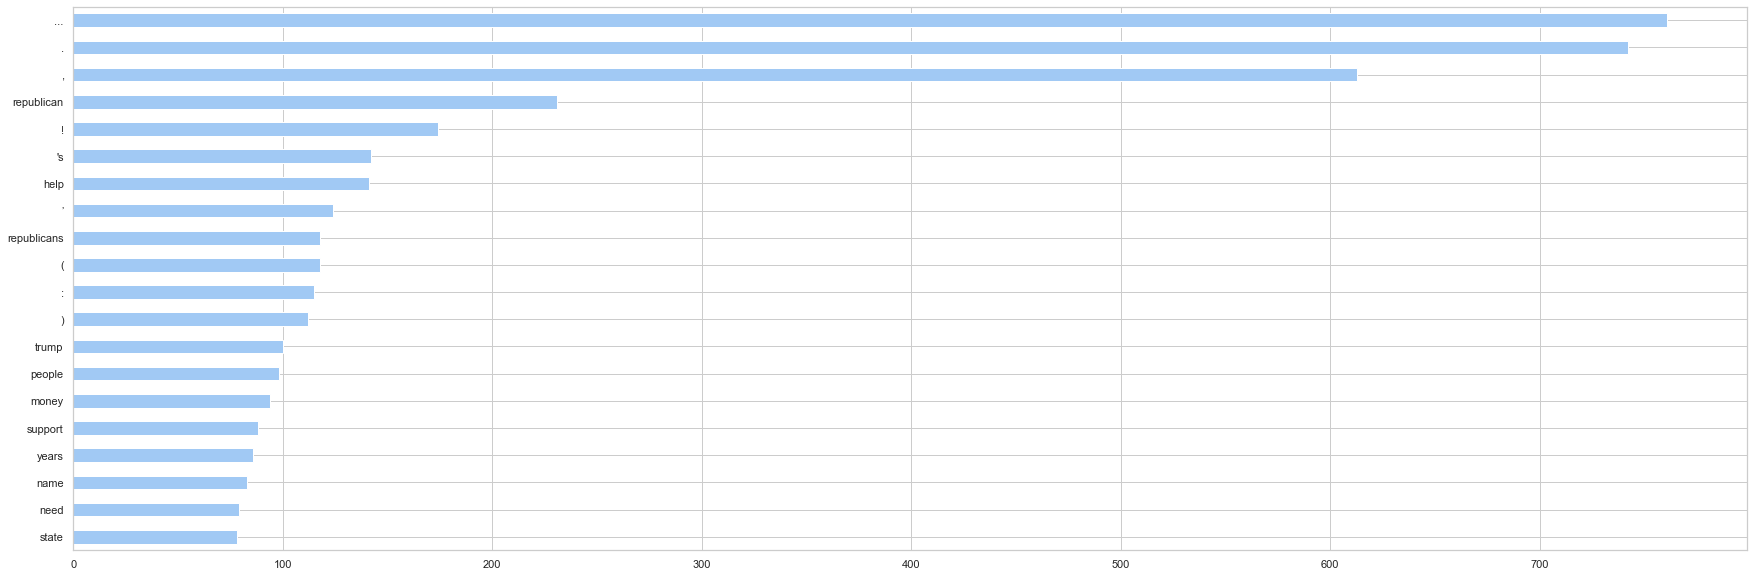

In [237]:
rep_rslt.index.value_counts().head(20).sort_values(ascending=True).plot(kind='barh',figsize=(30,10))

In [222]:
# rep_rslt['count'] =1
# rep_rslt=rep_rslt.groupby('Word').agg({'count':'sum'})


In [243]:
rep_counts=pd.DataFrame(rep_rslt.index.value_counts()).reset_index()


In [245]:
rep_counts['wd_pct']=rep_counts['Word']/864

In [246]:
rep_counts.sort_values('wd_pct',ascending=False)

,index,Word,wd_pct
0,...,761,0.868721
1,.,742,0.847032
2,",",613,0.699772
3,republican,231,0.263699
4,!,174,0.198630
5,'s,142,0.162100
6,help,141,0.160959
7,’,124,0.141553
8,republicans,118,0.134703
9,(,118,0.134703


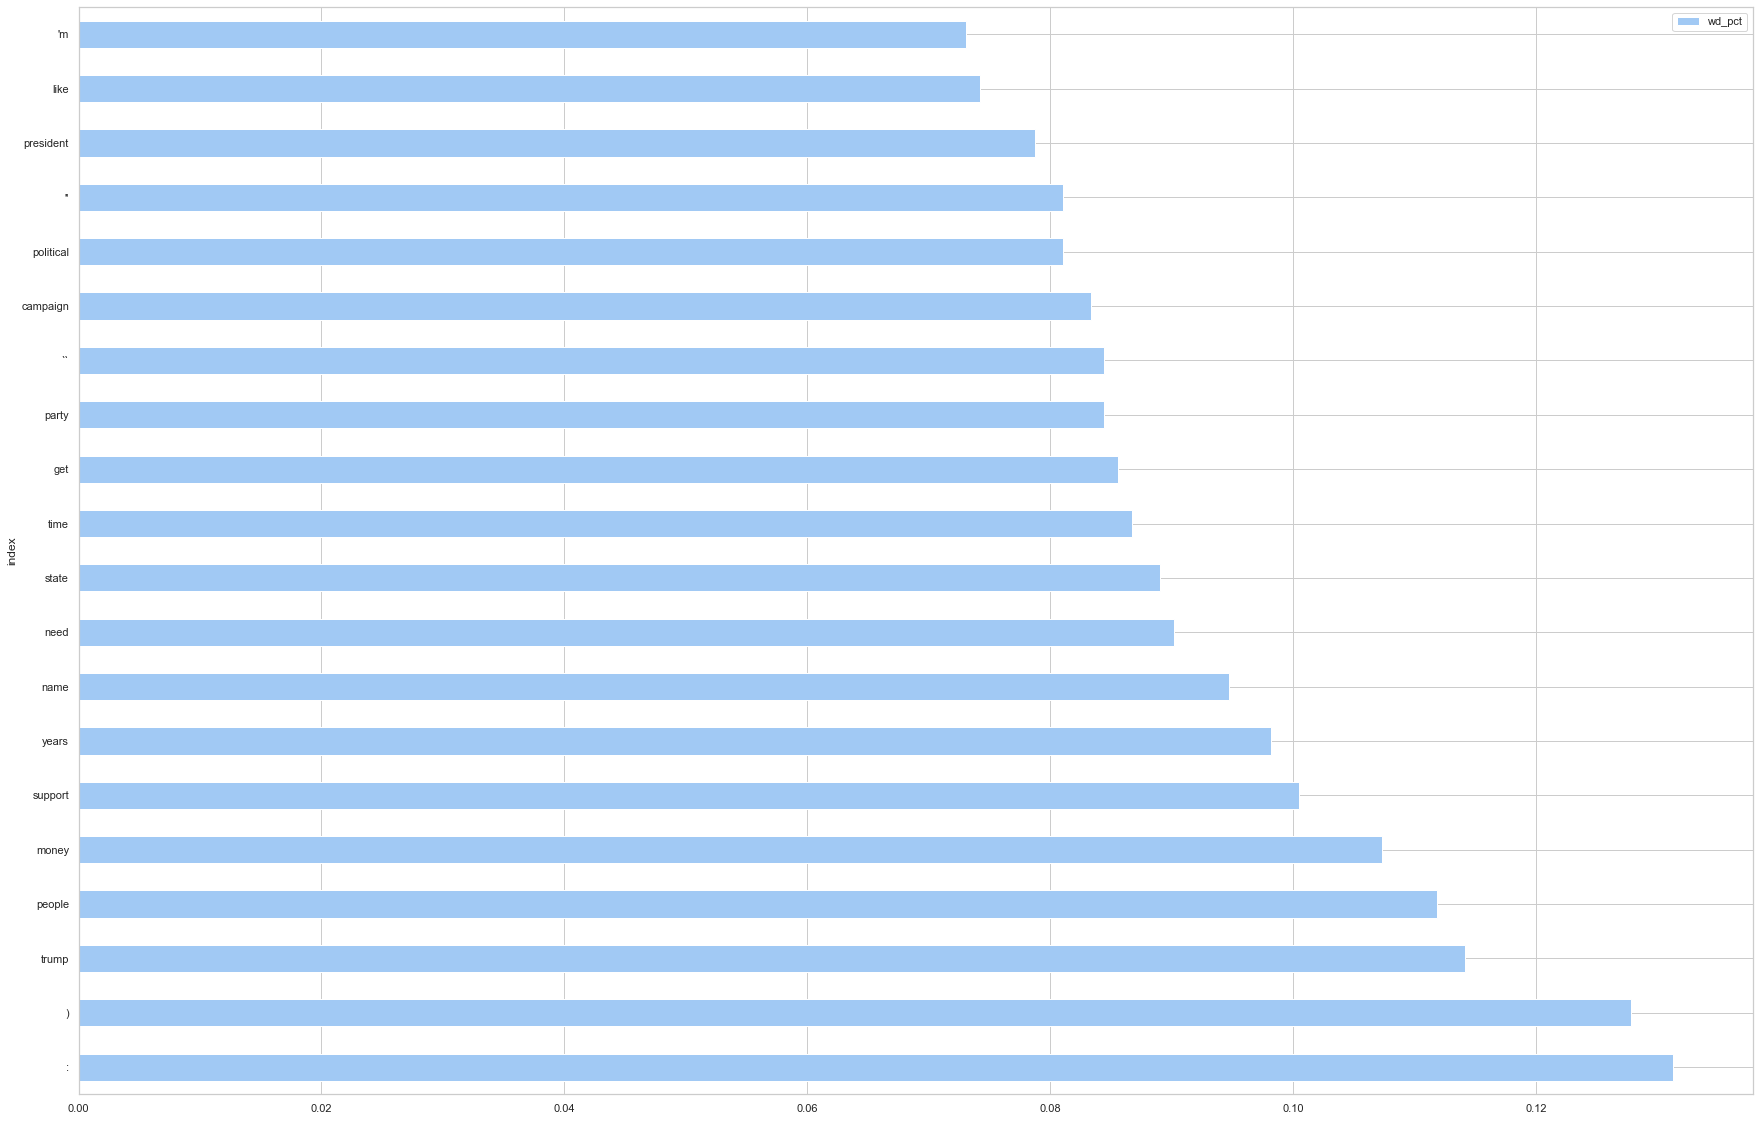

In [249]:
rep_counts.sort_values('wd_pct',ascending=False)[10:30].plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))

In [250]:
#campaigns with the word democrat
top_N = 100000
dem_rslt =pd.DataFrame()
for index, row in df[df['tag']=='dem'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    dem_rslt=dem_rslt.append(rslt)

All frequencies, including STOPWORDS:
                    Word  Frequency
0                     to          3
1                    the          3
2                     in          2
3                     we          2
4                   have          2
5                  raise          2
6                      a          2
7                  print          1
8                vaccine          1
9                 safety          1
10             statement          1
11                  with          1
12                   all          1
13                   our          1
14                 names          1
15                beside          1
16                    it          1
17                 press          1
18              democrat          1
19                     $          1
20                 2,268          1
21                   for          1
22                  half          1
23                  page          1
24         advertisement          1
25                     .  

           Word  Frequency
0            to          5
1            we          4
2            in          4
3          help          3
4             .          3
5          need          2
6             a          2
7      november          2
8           the          2
9          your          1
10         fund          1
11        video          1
12      project          1
13    democrats          1
14          win          1
15        young          1
16         team          1
17           of          1
18  progressive          1
19          and          1
20     democrat          1
21   volunteers          1
22           is          1
23       coming          1
24     together          1
25        elect          1
26   candidates          1
27     kootenai          1
28       county          1
29         feel          1
30         that          1
31        order          1
32       really          1
33          get          1
34          out          1
35         vote          1
3

All frequencies, including STOPWORDS:
            Word  Frequency
0              ,          5
1            the          3
2             on          2
3             to          2
4          close          2
5             up          2
6              !          2
7             we          2
8           will          2
9       students          1
10            of          1
11       esparto          1
12          high          1
13        school          1
14           are          1
15     traveling          1
16             a          1
17           fun          1
18           and          1
19   educational          1
20          trip          1
21    washington          1
22            dc          1
23          with          1
24    foundation          1
25        nation          1
26             ’          1
27             s          1
28       leading          1
29    non-profit          1
30  non-partisan          1
31         civic          1
32     education          1
33  organi

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          5
1          new          4
2         york          4
3        state          4
4        young          4
5           of          3
6    democrats          3
7          for          2
8            a          2
9            .          2
10       thank          1
11         you          1
12          so          1
13        much          1
14     helping          1
15        make          1
16          my          1
17       dream          1
18       being          1
19    delegate          1
20    democrat          1
21           ’          1
22           s          1
23     reality          1
24         are          1
25    official          1
26       youth          1
27         arm          1
28  democratic          1
29   committee          1
30   represent          1
31     between          1
32        ages          1
33         ...          1
All frequencies, including STOPWORDS:
            Wo

            Word  Frequency
0              .          3
1             to          3
2             is          2
3      democrats          2
4            the          2
5             my          1
6           name          1
7             es          1
8        .making          1
9       disabled          1
10          feel          1
11         proud          1
12         right          1
13            be          1
14       counted          1
15           .my          1
16          goal          1
17          make          1
18          sure          1
19  disadvantage          1
20         .have          1
21          ride          1
22          vote          1
23             !          1
All frequencies, including STOPWORDS:
     Word  Frequency
0      to          1
1  defeat          1
2      ro          1
3  khanna          1
4       .          1
All frequencies, including STOPWORDS:
         Word  Frequency
0          to          4
1         for          2
2           .          

            Word  Frequency
0             in          3
1            ccd          2
2            the          2
3              .          2
4           have          2
5            and          2
6              ,          2
7        citadel          1
8        college          1
9      democrats          1
10             (          1
11             )          1
12            is          1
13           its          1
14         first          1
15          year          1
16            of          1
17     existence          1
18           but          1
19           has          1
20          made          1
21             a          1
22          huge          1
23        impact          1
24     community          1
25            we          1
26        logged          1
27         close          1
28            to          1
29           100          1
30         hours          1
31       working          1
32            on          1
33         state          1
34       federal    

             Word  Frequency
0              to          4
1       president          1
2           trump          1
3           needs          1
4              be          1
5      re-elected          1
6             and          1
7   organizations          1
8            like          1
9            this          1
10           need          1
11          funds          1
12            get          1
13           word          1
14            out          1
15              .          1
16         please          1
17           help          1
All frequencies, including STOPWORDS:
           Word  Frequency
0           the          2
1             i          1
2            am          1
3       raising          1
4         money          1
5            to          1
6        defeat          1
7   republicans          1
8            so          1
9            us          1
10    democrats          1
11          can          1
12         gain          1
13      control          1
14    

           Word  Frequency
0           all          4
1             ?          3
2     donations          3
3             ,          3
4             $          2
5             =          2
6           and          2
7         while          2
8           the          2
9     community          2
10            .          2
11     democrat          1
12           vs          1
13   republican          1
14            -          1
15          who          1
16        helps          1
17         more          1
18          odd          1
19  republicans          1
20         even          1
21    democrats          1
22          let          1
23       settle          1
24         this          1
25       debate          1
26         once          1
27          for          1
28      helping          1
29          out          1
30         will          1
31           go          1
32           to          1
33       people          1
34      animals          1
35    charities          1
3

           Word  Frequency
0           the          5
1            of          4
2            to          2
3             ,          2
4       purpose          1
5          this          1
6          fund          1
7         drive          1
8            is          1
9     establish          1
10            a          1
11    political          1
12       action          1
13    committee          1
14       tasked          1
15         with          1
16   recruiting          1
17  fundraising          1
18          and          1
19      general          1
20      support          1
21     centrist          1
22   democratic          1
23   candidates          1
24           in          1
25        inner          1
26       cities          1
27       across          1
28       united          1
29       states          1
30            .          1
31   monolithic          1
32      control          1
33        black          1
34         vote          1
35          has          1
3

52        ...          1
All frequencies, including STOPWORDS:
         Word  Frequency
0         the          4
1           ,          4
2         and          3
3           .          3
4          my          2
5           i          2
6        with          2
7      blekic          2
8      family          2
9          in          2
10       that          2
11        you          2
12         to          2
13       name          1
14         is          1
15      angie          1
16   filipsic          1
17         am          1
18    friends          1
19       boys          1
20     attend          1
21       high          1
22     school          1
23     medina          1
24        are          1
25     njrotc          1
26   together          1
27       here          1
28        st.          1
29  augustine          1
30         fl          1
31        ask          1
32       read          1
33      story          1
34      below          1
35         if          1
36        ca

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          5
1           the          3
2           and          3
3           for          2
4            in          2
5             .          2
6            we          2
7          yale          1
8       college          1
9     democrats          1
10          are          1
11  intentional          1
12    advocates          1
13  progressive          1
14       change          1
15          new          1
16        haven          1
17  connecticut          1
18       across          1
19      country          1
20        fight          1
21   candidates          1
22       causes          1
23         that          1
24      advance          1
25        equal          1
26      justice          1
27        human          1
28      dignity          1
29  empowerment          1
30           of          1
31          all          1
32       people          1
33        while          1
34    resisting  

                   Word  Frequency
0                     :          5
1                     ,          4
2                   the          2
3                   our          2
4                    to          2
5                    my          2
6                  2018          1
7             elections          1
8                   are          1
9                  most          1
10            important          1
11             midterms          1
12                   of          1
13             lifetime          1
14                    .          1
15               donate          1
16                    #          1
17  grassrootsisgreener          1
18                 tour          1
19              support          1
20            volunteer          1
21                 work          1
22             electing          1
23            democrats          1
24               across          1
25              country          1
26          albuquerque          1
27                  

              Word  Frequency
0              and          3
1               to          2
2                a          2
3   accountability          1
4               pa          1
5               is          1
6               an          1
7    all-volunteer          1
8         feminist          1
9       collective          1
10       committed          1
11         holding          1
12         elected          1
13           party          1
14       officials          1
15     accountable          1
16             for          1
17          sexual          1
18      misconduct          1
19        violence          1
20               .          1
21              we          1
22            came          1
23        together          1
24              in          1
25            2018          1
26          demand          1
27           state          1
28         senator          1
29          daylin          1
30           leach          1
31              's          1
32     res

             Word  Frequency
0               a          5
1               .          4
2               i          3
3              my          2
4              is          2
5              am          2
6             the          2
7              of          2
8              in          2
9             and          2
10          hello          1
11           name          1
12       chastity          1
13          abney          1
14         rising          1
15         senior          1
16             at          1
17     university          1
18          south          1
19       carolina          1
20          aiken          1
21          major          1
22      political          1
23        science          1
24           with          1
25  concentration          1
26        pre-law          1
27          minor          1
28       criminal          1
29        justice          1
30      currently          1
31        serving          1
32             as          1
33         mem

All frequencies, including STOPWORDS:
             Word  Frequency
0             and          3
1              to          3
2               ,          3
3               a          2
4             the          2
5            post          2
6            cafe          2
7            have          2
8               .          2
9             our          2
10            for          2
11           many          2
12             we          1
13           were          1
14        shocked          1
15       saddened          1
16             as          1
17      community          1
18          today          1
19            see          1
20      following          1
21           from          1
22         nicole          1
23        mccoomb          1
24          owner          1
25             of          1
26        madison          1
27             's          1
28              :          1
29             ``          1
30           this          1
31             is          1
32   

All frequencies, including STOPWORDS:
          Word  Frequency
0           we          3
1            ,          3
2           to          3
3            !          2
4          the          2
5            .          2
6           us          2
7          and          2
8     facebook          2
9          has          2
10        ￼￼￼￼          1
11         hey          1
12        guys          1
13          do          1
14         not          1
15     receive          1
16    millions          1
17        from          1
18  government          1
19      george          1
20       soros          1
21          or          1
22     silicon          1
23      valley          1
24         are          1
25   supported          1
26          by          1
27         you          1
28      people          1
29        here          1
30          at          1
31   'lgbtrump          1
32           -          1
33        gays          1
34         for          1
35       trump          1


            Word  Frequency
0             to          4
1              a          3
2            the          3
3              ,          2
4            and          2
5             by          2
6             hi          1
7       everyone          1
8              !          1
9             in          1
10      response          1
11        recent          1
12    outrageous          1
13     political          1
14        events          1
15      continue          1
16         build          1
17      movement          1
18        fueled          1
19     kavanaugh          1
20  confirmation          1
21            we          1
22         would          1
23          love          1
24       release          1
25         music          1
26         video          1
27          that          1
28     expresses          1
29          both          1
30   frustration          1
31   empowerment          1
32            of          1
33         women          1
34         today    

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          4
1            ,          4
2         fire          3
3            a          3
4   bloomsbury          2
5           to          2
6            .          2
7     extended          2
8           of          2
9           on          1
10    november          1
11        28th          1
12          at          1
13         9pm          1
14     company          1
15       along          1
16        with          1
17    multiple          1
18    agencies          1
19   responded          1
20        that          1
21      ripped          1
22     through          1
23      duplex          1
24         had          1
25        only          1
26         one          1
27        half          1
28       house          1
29         but          1
30   destroyed          1
31       great          1
32      amount          1
33  belongings          1
34     fulpers          1
35   including          1


All frequencies, including STOPWORDS:
             Word  Frequency
0             the          5
1               !          3
2          dekalb          2
3              to          2
4        dunwoody          2
5            july          2
6             4th          2
7          parade          2
8              in          2
9               a          2
10         please          1
11           help          1
12           send          1
13           dems          1
14            for          1
15           last          1
16            two          1
17          years          1
18              ,          1
19      democrats          1
20          house          1
21       district          1
22             79          1
23           have          1
24            had          1
25      wonderful          1
26           time          1
27  participating          1
28              ’          1
29              s          1
30              .          1
31             it          1
32   

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          8
1            my          5
2           the          4
3             i          3
4           and          3
5           ...          3
6         cause          2
7            is          2
8           for          2
9    resistance          1
10         what          1
11         live          1
12            .          1
13      current          1
14        focus          1
15         much          1
16         like          1
17        yours          1
18      imagine          1
19      driving          1
20          out          1
21   malevolent          1
22  trump/pence          1
23       regime          1
24       ethics          1
25   conscience          1
26         love          1
27     humanity          1
28       demand          1
29     dedicate          1
30         full          1
31     strength          1
32           of          1
33    abilities          1
34      passion  

                     Word  Frequency
0                       i          4
1                       a          3
2                      to          3
3                  bernie          3
4                       .          3
5                     was          2
6                 elected          2
7                 sanders          2
8                     the          2
9                    utah          2
10                     's          2
11                     as          1
12               national          1
13               delegate          1
14                   cast          1
15                   vote          1
16                    for          1
17                   this          1
18                 summer          1
19                     at          1
20             democratic          1
21             convention          1
22                     am          1
23               activist          1
24                     in          1
25                 verify          1
2

All frequencies, including STOPWORDS:
                                                 Word  Frequency
0                                                   !          3
1                                                help          2
2                                                  is          2
3                                                http          1
4                                                   :          1
5   //www.appeal-democrat.com/news/brownsville-man...          1
6                                              please          1
7                                                 any          1
8                                            donation          1
9                                              amount          1
10                                            greatly          1
11                                        appreciated          1
12                                                the          1
13                                             prune

All frequencies, including STOPWORDS:
            Word  Frequency
0             is          6
1              .          5
2            rob          4
3            the          4
4            and          2
5              a          2
6             he          2
7          party          2
8             my          1
9           name          1
10         erica          1
11             i          1
12            am          1
13       sighted          1
14         guide          1
15           for          1
16        kerney          1
17           was          1
18       elected          1
19            by          1
20           his          1
21            to          1
22        attend          1
23           dnc          1
24          2016          1
25            in          1
26  philadelphia          1
27          only          1
28      delegate          1
29          from          1
30       indiana          1
31           who          1
32       totally          1
33        

          Word  Frequency
0            i          4
1          was          2
2           to          2
3      senator          2
4          the          2
5            .          2
6           in          2
7           hi          1
8            ,          1
9           my          1
10        name          1
11          is          1
12      hannah          1
13  wroblewski          1
14         and          1
15     elected          1
16          as          1
17           a          1
18        2016          1
19        pleo          1
20    national          1
21    delegate          1
22     pledged          1
23      bernie          1
24     sanders          1
25        from          1
26       great          1
27       state          1
28          of          1
29    nebraska          1
30     started          1
31     getting          1
32    involved          1
33    politics          1
34       while          1
35        high          1
36      school          1
37       whe

All frequencies, including STOPWORDS:
           Word  Frequency
0             !          4
1             ,          3
2            to          3
3           all          2
4           the          2
5    convention          2
6             .          2
7          cost          2
8           for          2
9           and          2
10         will          2
11         this          2
12            i          2
13         need          1
14          met          1
15        thank          1
16          you          1
17         send          1
18       jeanne          1
19        smith          1
20            a          1
21  transgender          1
22        woman          1
23   democratic          1
24     national          1
25           it          1
26           is          1
27    estimated          1
28         that          1
29         each          1
30     delegate          1
31        hotel          1
32       travel          1
33         food          1
34           be  

All frequencies, including STOPWORDS:
         Word  Frequency
0           ,          8
1         the          2
2          by          2
3         her          2
4         and          2
5         for          2
6        most          1
7    horrific          1
8       words          1
9         you          1
10      could          1
11       ever          1
12       hear          1
13          :          1
14       your          1
15     mother          1
16     sister          1
17       wife          1
18         or          1
19   daughter          1
20        has          1
21       been          1
22   brutally          1
23   attacked          1
24          a          1
25   predator          1
26       body          1
27  mutilated          1
28      raped          1
29   tortured          1
30       then          1
31       left          1
32       dead          1
33          .          1
34       only          1
35    posting          1
36         on          1
37   faceboo

All frequencies, including STOPWORDS:
            Word  Frequency
0            and          3
1              i          2
2           have          2
3            gun          2
4       violence          2
5              .          2
6             in          2
7            for          2
8              ,          2
9              a          2
10            my          1
11          wife          1
12   experienced          1
13           the          1
14      horrific          1
15       effects          1
16            of          1
17          2015          1
18           our          1
19      daughter          1
20        alison          1
21           was          1
22        gunned          1
23          down          1
24            on          1
25          live          1
26    television          1
27         while          1
28     reporting          1
29         wdbj7          1
30       roanoke          1
31  virginia—her          1
32          home          1
33        

           Word  Frequency
0             ,          5
1           and          4
2           you          3
3       elected          2
4           for          2
5       senator          2
6       sanders          2
7            if          2
8         needs          2
9            my          1
10         name          1
11           is          1
12        susan          1
13         soto          1
14       palmer          1
15            i          1
16          was          1
17           on          1
18         june          1
19           19          1
20         2016          1
21           as          1
22            a          1
23        party          1
24       leader          1
25     official          1
26            (          1
27         pleo          1
28            )          1
29     delegate          1
30       bernie          1
31            .          1
32      support          1
33          the          1
34    political          1
35   revolution          1
3

All frequencies, including STOPWORDS:
         Word  Frequency
0           ,          4
1          is          4
2           .          4
3          we          3
4     because          2
5          of          2
6         not          2
7          it          2
8         and          2
9          to          2
10       with          2
11        our          2
12          (          1
13        pic          1
14       from          1
15      hueco          1
16      tanks          1
17         tx          1
18          )          1
19        why          1
20       does          1
21   standing          1
22       rock          1
23     matter          1
24          ?          1
25      abuse          1
26     native          1
27  americans          1
28          a          1
29      thing          1
30    history          1
31    current          1
32      alive          1
33       ours          1
34       deal          1
35         if          1
36         do          1
37        ac

          Word  Frequency
0            ,          5
1            (          3
2     daughter          2
3           to          2
4         lost          2
5          her          2
6    apartment          2
7           in          2
8          the          2
9         fire          2
10           .          2
11           )          2
12       their          2
13      damage          2
14      nicole          1
15           –          1
16     richena          1
17     johnson          1
18         has          1
19          w.          1
20      steele          1
21        lane          1
22        last          1
23        week          1
24       nikki          1
25     husband          1
26        neal          1
27         and          1
28        abby          1
29        have          1
30         all          1
31          of          1
32  belongings          1
33         due          1
34  fire/smoke          1
35       santa          1
36        rosa          1
37   displac

All frequencies, including STOPWORDS:
             Word  Frequency
0             not          3
1              nj          2
2             gop          2
3            from          2
4               .          2
5             the          2
6            with          2
7             and          2
8              to          2
9               i          1
10             am          1
11        running          1
12            for          1
13          state          1
14      committee          1
15         hudson          1
16         county          1
17        suffers          1
18           only          1
19              a          1
20    significant          1
21            gap          1
22             in          1
23   registration          1
24      democrats          1
25            but          1
26           also          1
27              (          1
28        related          1
29              )          1
30            its          1
31      inability          1
32   

           Word  Frequency
0           for          3
1             ,          3
2             i          2
3            am          2
4            my          2
5           the          2
6    democratic          2
7      national          2
8        bernie          2
9             .          2
10           to          2
11         this          2
12      wyoming          2
13        hello          1
14      friends          1
15            !          1
16  fundraising          1
17         trip          1
18         2016          1
19   convention          1
20           as          1
21            a          1
22     delegate          1
23      sanders          1
24     thrilled          1
25           be          1
26         able          1
27           do          1
28      amazing          1
29        thing          1
30       fellow          1
31   supporters          1
32    democrats          1
33        women          1
34          and          1
35        youth          1
3

All frequencies, including STOPWORDS:
             Word  Frequency
0              we          4
1             the          4
2              in          3
3             our          2
4             and          2
5        district          2
6             had          1
7           great          1
8         success          1
9            with          1
10     canvassing          1
11        efforts          1
12        support          1
13             of          1
14            get          1
15            out          1
16           vote          1
17        project          1
18           know          1
19           that          1
20           this          1
21       strategy          1
22          works          1
23              !          1
24          order          1
25             to          1
26           flip          1
27          102nd          1
28          state          1
29       assembly          1
30           19th          1
31  congressional          1
32   

           Word  Frequency
0           the          5
1             ,          3
2            to          3
3         y'all          2
4             ?          2
5           are          2
6            on          2
7             i          2
8             ’          2
9         guess          1
10         what          1
11           we          1
12       headed          1
13          dnc          1
14            !          1
15        still          1
16      running          1
17         with          1
18         lula          1
19        right          1
20         june          1
21         12th          1
22          was          1
23  unanimously          1
24     approved          1
25        serve          1
26  credentials          1
27    committee          1
28          for          1
29        north          1
30     carolina          1
31   delegation          1
32         2016          1
33   democratic          1
34     national          1
35   convention          1
3

All frequencies, including STOPWORDS:
                 Word  Frequency
0                   i          3
1                  to          3
2                   .          3
3                  am          2
4             elected          2
5                 the          2
6                  my          2
7             running          2
8                  of          2
9             humbled          1
10               have          1
11               been          1
12                 as          1
13                  a          1
14           delegate          1
15         california          1
16         democratic          1
17              party          1
18              state          1
19        conventions          1
20                 it          1
21                 is          1
22              first          1
23               time          1
24                for          1
25                 an          1
26           position          1
27                was          1
28   

       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
            Word  Frequency
0              ,          5
1              i          5
2             my          4
3         school          4
4            and          3
5             in          3
6             am          2
7              .          2
8        student          2
9              ’          2
10             s          2
11             ;          2
12            of          2
13          name          1
14            is          1
15        alyssa          1
16        gaines          1
17      freshman          1
18            at          1
19          park          1
20         tudor          1
21  indianapolis          1
22            an          1
23        active          1
24        within          1
25     community          1
26          this          1
27          year          1
28        played          1
29    volleyball          1
30

All frequencies, including STOPWORDS:
             Word  Frequency
0              in          4
1               ,          3
2               .          3
3             and          3
4              is          2
5              to          2
6             the          2
7              as          2
8              at          2
9             our          2
10           wcrs          1
11      greenwood          1
12          south          1
13       carolina          1
14          going          1
15      broadcast          1
16           live          1
17           from          1
18            rnc          1
19      cleveland          1
20             oh          1
21           july          1
22           this          1
23     convention          1
24       promises          1
25             be          1
26       exciting          1
27  controversial          1
28            any          1
29         recent          1
30        history          1
31         1450am          1
32   

All frequencies, including STOPWORDS:
             Word  Frequency
0             the          3
1              of          3
2              as          2
3              my          2
4               a          2
5              at          2
6             you          1
7             may          1
8            know          1
9          sister          1
10            and          1
11              i          1
12           have          1
13          great          1
14          honor          1
15   representing          1
16  congressional          1
17       district          1
18              3          1
19      delegates          1
20            for          1
21        hillary          1
22        clinton          1
23     democratic          1
24       national          1
25     convention          1
26             in          1
27         philly          1
28          along          1
29           with          1
30        brother          1
31         daniel          1
32   

All frequencies, including STOPWORDS:
              Word  Frequency
0                i          5
1               to          3
2                .          3
3              and          3
4               am          3
5          running          3
6               my          2
7        treasurer          2
8               as          2
9              the          2
10              hi          1
11             all          1
12               ,          1
13         welcome          1
14     fundraising          1
15            page          1
16            name          1
17              is          1
18       christian          1
19           smith          1
20             for          1
21          mobile          1
22          county          1
23               a          1
24        democrat          1
25         believe          1
26       represent          1
27           voice          1
28              of          1
29          people          1
30         because          1
31

All frequencies, including STOPWORDS:
             Word  Frequency
0               ,          7
1             the          4
2             and          3
3              as          1
4               a          1
5          family          1
6              of          1
7     foodservice          1
8               e          1
9               &          1
10              s          1
11        dealers          1
12      suppliers          1
13      customers          1
14        located          1
15     throughout          1
16         united          1
17         states          1
18         canada          1
19         cayman          1
20        islands          1
21             we          1
22            are          1
23     devastated          1
24             by          1
25  unprecedented          1
26         impact          1
27      wildfires          1
28             in          1
29         sonoma          1
30           napa          1
31        present          1
32   

All frequencies, including STOPWORDS:
              Word  Frequency
0                ,          4
1              all          2
2              and          2
3               to          2
4             help          2
5               of          2
6               in          2
7              for          2
8                .          2
9               hi          1
10              my          1
11            name          1
12              is          1
13        kimberly          1
14               i          1
15               ’          1
16               m          1
17     fundraising          1
18            with          1
19             the          1
20           costs          1
21       attending          1
22           young          1
23       democrats          1
24         america          1
25        national          1
26      convention          1
27    indianapolis          1
28         indiana          1
29            from          1
30            july          1
31

           Word  Frequency
0             i          5
1         signs          4
2            to          3
3          have          2
4           and          2
5             !          2
6          made          2
7             ,          2
8           for          2
9             $          2
10            .          2
11          the          2
12           an          1
13         idea          1
14         need          1
15         your          1
16         help          1
17         want          1
18         yard          1
19          put          1
20           up          1
21          all          1
22         over          1
23         long          1
24       island          1
25  encouraging          1
26       fellow          1
27    democrats          1
28         vote          1
29           on          1
30          nov          1
31           6.          1
32        found          1
33            a          1
34         deal          1
35       online          1
3

All frequencies, including STOPWORDS:
           Word  Frequency
0             ,          9
1           the          7
2            of          4
3            as          3
4           law          2
5             a          2
6          upon          2
7             i          1
8          have          1
9          been          1
10           on          1
11          air          1
12          for          1
13          six          1
14        years          1
15           in          1
16  chattanooga          1
17    defending          1
18        godly          1
19     concepts          1
20         such          1
21     marriage          1
22         free          1
23      markets          1
24          god          1
25           's          1
26       rights          1
27       people          1
28     property          1
29    certainty          1
30       equity          1
31    principle          1
32       claims          1
33         good          1
34         news  

All frequencies, including STOPWORDS:
          Word  Frequency
0          the          6
1           my          3
2            .          3
3            i          3
4           in          2
5            ,          2
6       blondy          2
7       baruti          2
8           am          2
9           of          2
10          to          2
11          if          1
12        they          1
13           (          1
14  immigrants          1
15           )          1
16         can          1
17         not          1
18        come          1
19         let          1
20           ’          1
21           s          1
22       bring          1
23        them          1
24        help          1
25           !          1
26        name          1
27          is          1
28      author          1
29        book          1
30           “          1
31  incredible          1
32        true          1
33       story          1
34    unlikely          1
35     journey          1


All frequencies, including STOPWORDS:
           Word  Frequency
0             i          4
1             ,          2
2         would          2
3            if          2
4            to          2
5            of          2
6             .          2
7       looking          1
8            at          1
9           how          1
10    americans          1
11   especially          1
12    democrats          1
13         have          1
14           no          1
15      problem          1
16        given          1
17         rich          1
18      corrupt          1
19  politicians          1
20          and          1
21         govt          1
22    officials          1
23        money          1
24      thought          1
25          see          1
26        these          1
27         very          1
28         same          1
29       people          1
30       donate          1
31            a          1
32       better          1
33        cause          1
34      helping  

All frequencies, including STOPWORDS:
          Word  Frequency
0           to          3
1            ,          3
2          for          2
3      support          2
4          the          2
5         food          2
6          and          2
7     facebook          1
8        event          1
9     donation          1
10   drop-offs          1
11          we          1
12         are          1
13     raising          1
14       money          1
15        baby          1
16      supply          1
17       drive          1
18      united          1
19      states          1
20       coast          1
21       guard          1
22        that          1
23          is          1
24       being          1
25      hosted          1
26          by          1
27   riverside          1
28      county          1
29       young          1
30   democrats          1
31           .          1
32        this          1
33  fundraiser          1
34         has          1
35        been          1


All frequencies, including STOPWORDS:
               Word  Frequency
0               the          3
1          governor          2
2                 :          2
3               and          2
4                 .          2
5                of          2
6          two-term          1
7        democratic          1
8              john          1
9      hickenlooper          1
10               is          1
11     term-limited          1
12              can          1
13              not          1
14             seek          1
15       reelection          1
16            major          1
17       candidates          1
18              are          1
19            jared          1
20            polis          1
21                (          1
22         democrat          1
23                )          1
24               an          1
25     entrepreneur          1
26   philanthropist          1
27                ,          1
28               he          1
29           served          1
3

All frequencies, including STOPWORDS:
            Word  Frequency
0             to          4
1              i          4
2              ,          3
3              .          3
4             of          2
5            has          2
6             my          2
7            out          2
8             in          2
9      attending          1
10           the          1
11    university          1
12      oklahoma          1
13        always          1
14          been          1
15         dream          1
16           but          1
17        seemed          1
18   far-fetched          1
19           due          1
20     financial          1
21  difficulties          1
22          that          1
23            's          1
24           why          1
25            'm          1
26      reaching          1
27           you          1
28          hope          1
29       receive          1
30           aid          1
31          from          1
32     community          1
33        

            Word  Frequency
0             to          4
1            our          2
2              :          2
3          trump          2
4              !          2
5             we          2
6        mission          1
7         fellow          1
8       patriots          1
9              ,          1
10        please          1
11          help          1
12            us          1
13            in          1
14       helping          1
15         fight          1
16      re-elect          1
17     wonderful          1
18     president          1
19        donald          1
20             j          1
21           are          1
22             a          1
23            ``          1
24      sneakers          1
25            on          1
26           the          1
27        ground          1
28            ''          1
29  organization          1
30          that          1
31          gets          1
32   republicans          1
33    registered          1
34           and    

All frequencies, including STOPWORDS:
             Word  Frequency
0             and          7
1             the          3
2          please          2
3           facts          2
4             for          2
5               ;          2
6             see          2
7               ,          2
8            note          1
9               :          1
10      following          1
11           will          1
12       document          1
13      situation          1
14           that          1
15          makes          1
16     imperative          1
17           this          1
18           plea          1
19           help          1
20          james          1
21             ``          1
22            jim          1
23             ''          1
24         craven          1
25         family          1
26      documents          1
27        witness          1
28     statements          1
29      responses          1
30  documentation          1
31             of          1
32   

       Word  Frequency
0   summary          1
1       was          1
2  nonetype          1
All frequencies, including STOPWORDS:
           Word  Frequency
0             $          3
1            to          3
2           the          3
3             ,          2
4            or          2
5          this          2
6          will          2
7            of          2
8           and          2
9    democratic          2
10         your          1
11   individual          1
12            5          1
13           10          1
14          20+          1
15    donations          1
16     campaign          1
17         fund          1
18    placement          1
19       simple          1
20      message          1
21           on          1
22        signs          1
23   billboards          1
24         that          1
25        plant          1
26        seeds          1
27      thought          1
28          get          1
29  traditional          1
30        black          1
31    

All frequencies, including STOPWORDS:
             Word  Frequency
0         chronic          3
1         fatigue          3
2        syndrome          3
3               a          3
4             the          3
5               .          2
6        epidemic          2
7              is          1
8       neglected          1
9   international          1
10         public          1
11         health          1
12      emergency          1
13        history          1
14             of          1
15       emerging          1
16            can          1
17             be          1
18          found          1
19             in          1
20       cover-up          1
21              ,          1
22           book          1
23           that          1
24     pioneering          1
25            cfs          1
26     journalist          1
27        hillary          1
28        johnson          1
29         called          1
30             ``          1
31      important          1
32   

                Word  Frequency
0  stoptrumpwall.org          1
1  stoptrumpwall.com          1
2  stoptrumpwall.net          1
3            bridges          1
4                  ,          1
5                not          1
6                  w          1
7                ...          1
All frequencies, including STOPWORDS:
           Word  Frequency
0             .          5
1           the          4
2            ``          3
3            ''          3
4             i          2
5          know          2
6         party          2
7           and          2
8             ,          2
9            on          2
10           am          1
11     starting          1
12            a          1
13     movement          1
14       called          1
15    tribalism          1
16     partisan          1
17     politics          1
18         have          1
19        taken          1
20         over          1
21           it          1
22           's          1
23         just          1

         Word  Frequency
0           a          4
1         and          3
2          of          2
3        what          2
4          to          2
5       there          1
6         are          1
7   thousands          1
8    homeless          1
9    veterans          1
10         in          1
11       need          1
12   friendly          1
13      boost          1
14        leg          1
15         up          1
16          .          1
17      makes          1
18         me          1
19      think          1
20          i          1
21        can          1
22         do          1
23  something          1
24          ,          1
25   anything          1
26         at          1
27        all          1
28        try          1
29       help          1
30        get          1
31       them          1
32    quality          1
33      place          1
34       live          1
35      clean          1
36    healthy          1
37       life          1
38      after          1


                    Word  Frequency
0                    and          5
1                    the          3
2                     in          2
3                america          2
4                      .          2
5   capitalist/socialist          2
6             volunteers          2
7              donations          2
8                    for          2
9              socialist          1
10               parties          1
11                   are          1
12               growing          1
13                around          1
14                 world          1
15                    as          1
16              outlined          1
17                   our          1
18                  book          1
19                 party          1
20                     ,          1
21                please          1
22                  look          1
23                    at          1
24                    we          1
25                  need          1
26            democratic    

All frequencies, including STOPWORDS:
              Word  Frequency
0          country          4
1               we          4
2                .          3
3                a          3
4                ,          3
5              our          3
6              the          2
7               is          2
8               of          2
9             this          1
10         belongs          1
11              to          1
12          people          1
13             not          1
14          unless          1
15            have          1
16          border          1
17        language          1
18             and          1
19         culture          1
20            must          1
21         contain          1
22       onslaught          1
23         persons          1
24        invading          1
25               ;          1
26         wherein          1
27              if          1
28            they          1
29              do          1
30             get          1
31

48         ...          1
All frequencies, including STOPWORDS:
            Word  Frequency
0           that          6
1             is          5
2             it          3
3            the          3
4              a          2
5             of          2
6              (          2
7              )          2
8             to          2
9           will          2
10           not          2
11            be          2
12             .          2
13          what          1
14           all          1
15         about          1
16             ?          1
17       project          1
18        connor          1
19        roland          1
20             ’          1
21             s          1
22            me          1
23     dedicated          1
24  distributing          1
25      pro-life          1
26      material          1
27          with          1
28        desire          1
29        unborn          1
30        babies          1
31       aborted          1
32      murd

          Word  Frequency
0           we          5
1            .          5
2         made          3
3          the          3
4          our          3
5      history          2
6       silent          2
7           is          2
8            ,          2
9            –          2
10           a          2
11        that          2
12      showed          1
13     america          1
14    majority          1
15          no          1
16      longer          1
17           ’          1
18          ve          1
19       hopes          1
20      dreams          1
21   limitless          1
22   potential          1
23     reality          1
24     created          1
25  government          1
26        once          1
27       again          1
28          of          1
29          by          1
30         and          1
31         for          1
32      people          1
33         but          1
34       those          1
35        same          1
36      forces          1
37       tri

All frequencies, including STOPWORDS:
            Word  Frequency
0             to          5
1            the          4
2           fund          2
3             of          2
4         defend          2
5         speech          2
6              ,          2
7      political          2
8            and          2
9           this          1
10            is          1
11    facilitate          1
12      creation          1
13            an          1
14  organization          1
15          free          1
16            on          1
17      internet          1
18  specifically          1
19             .          1
20          vast          1
21      majority          1
22           all          1
23         funds          1
24           are          1
25    litigation          1
26       against          1
27    technology          1
28         firms          1
29     establish          1
30             a          1
31          link          1
32       between          1
33       p

All frequencies, including STOPWORDS:
           Word  Frequency
0            to          6
1             i          5
2           the          3
3           for          3
4          want          2
5         leave          2
6     democrats          2
7            it          2
8             .          2
9           and          2
10         this          1
11      country          1
12      because          1
13           of          1
14         what          1
15          are          1
16       trying          1
17           do          1
18         ruin          1
19        would          1
20         like          1
21        raise          1
22       enough          1
23        money          1
24          buy          1
25           an          1
26      airline          1
27       ticket          1
28        about          1
29            $          1
30         1500          1
31           so          1
32          can          1
33  philippines          1
34        think  

              Word  Frequency
0               we          2
1              god          2
2                ,          2
3             that          2
4                “          2
5                ”          2
6              the          2
7              are          1
8              all          1
9         children          1
10              of          1
11             and          1
12              by          1
13             let          1
14              's          1
15        practice          1
16            what          1
17          preach          1
18               !          1
19      washington          1
20               —          1
21       president          1
22           trump          1
23            said          1
24              on          1
25          friday          1
26             his          1
27  administration          1
28             was          1
29        strongly          1
30     considering          1
31       releasing          1
32        

             Word  Frequency
0              to          5
1               a          3
2   investigation          2
3             the          2
4         corrupt          2
5               ,          2
6          trying          2
7              it          1
8               ’          1
9               s          1
10           time          1
11           have          1
12           into          1
13      democrats          1
14            and          1
15    politicians          1
16           tear          1
17           down          1
18     everything          1
19           that          1
20           u.s.          1
21         stands          1
22            for          1
23              .          1
24           with          1
25           your          1
26       donation          1
27            you          1
28           will          1
29           fund          1
30             an          1
31             by          1
32        private          1
33   investiga

         Word  Frequency
0           ,          5
1           .          3
2          to          3
3         for          2
4          in          2
5         was          2
6         his          2
7        what          2
8         him          2
9     teacher          2
10      three          1
11      years          1
12   starting          1
13       1982          1
14       mark          1
15     taylor          1
16      raped          1
17         by          1
18  principal          1
19      irwin          1
20   goldberg          1
21         at          1
22      adlai          1
23  stevenson          1
24       high          1
25     school          1
26         he          1
27      never          1
28        got          1
29    justice          1
30   happened          1
31    despite          1
32     trying          1
33       tell          1
34          a          1
35      about          1
36  happening          1
37       that          1
38      chose          1


            Word  Frequency
0            the          7
1              i          3
2              .          3
3           that          2
4         united          2
5         states          2
6             is          2
7           best          2
8             in          2
9        believe          1
10      becoming          1
11          very          1
12         thing          1
13      founding          1
14       fathers          1
15        feared          1
16     polarized          1
17           and          1
18        forced          1
19          into          1
20      factions          1
21       country          1
22         world          1
23           but          1
24         order          1
25            to          1
26          stay          1
27            on          1
28           top          1
29             ,          1
30  polarization          1
31           can          1
32           not          1
33         occur          1
34             ’    

All frequencies, including STOPWORDS:
         Word  Frequency
0         the          5
1          to          4
2           ,          3
3           i          2
4          of          2
5         and          2
6           .          2
7     support          1
8   president          1
9       trump          1
10       want          1
11     supply          1
12        him          1
13       with          1
14        all          1
15      money          1
16         he          1
17      needs          1
18    fulfill          1
19       wish          1
20  democrats          1
21       send          1
22   illegals          1
23  sanctuary          1
24     cities          1
25      chuck          1
26      nancy          1
27       cher          1
28     please          1
29        let          1
30       your          1
31     people          1
32       know          1
33     expect          1
34   millions          1
35   dreamers          1
36      thank          1
37        yo

All frequencies, including STOPWORDS:
          Word  Frequency
0           of          5
1           's          4
2          for          3
3          the          3
4       enough          3
5    president          2
6         2020          2
7           is          2
8            !          2
9            ,          2
10         are          2
11         you          2
12       tired          2
13  politician          2
14         mjk          1
15          at          1
16     malcolm          1
17         jay          1
18      kaplan          1
19          my          1
20        goal          1
21          to          1
22      foster          1
23          an          1
24     america          1
25        that          1
26    everyday          1
27    american          1
28     clinton          1
29        bush          1
30       trump          1
31           .          1
32      career          1
33           ?          1
34   celebrity          1
35        with          1


           Word  Frequency
0           the          5
1            of          3
2           and          3
3           our          2
4             ,          2
5        border          2
6             .          2
7     countries          1
8       current          1
9     situation          1
10    involving          1
11     southern          1
12     deserves          1
13         more          1
14    attention          1
15       issues          1
16        child          1
17   separation          1
18     building          1
19            a          1
20         wall          1
21        human          1
22       rights          1
23         have          1
24     affected          1
25    political          1
26         mind          1
27          set          1
28        moral          1
29   conscience          1
30      country          1
31           we          1
32      believe          1
33         that          1
34           by          1
35    capturing          1
3

In [252]:
dem_rslt.index.value_counts()

...             753
.               735
,               625
democrats       230
!               198
's              144
help            138
democratic      132
democrat        117
name            112
national        109
(               107
convention      107
:               106
)               106
people          105
money           101
’                99
state            95
elected          94
party            78
delegate         74
get              74
need             74
trump            73
support          72
us               72
america          69
one              68
president        66
               ... 
manuel            1
meaning           1
strangers         1
lacrosse          1
como              1
sickens           1
underserved       1
marijuana         1
rental            1
sneakers          1
krieg             1
win-win           1
approves          1
abdominal         1
marblehead        1
significanly      1
worcester         1
nominate          1
time…             1


In [253]:
dem_counts=pd.DataFrame(dem_rslt.index.value_counts()).reset_index()
dem_counts['wd_pct']=dem_counts['Word']/850

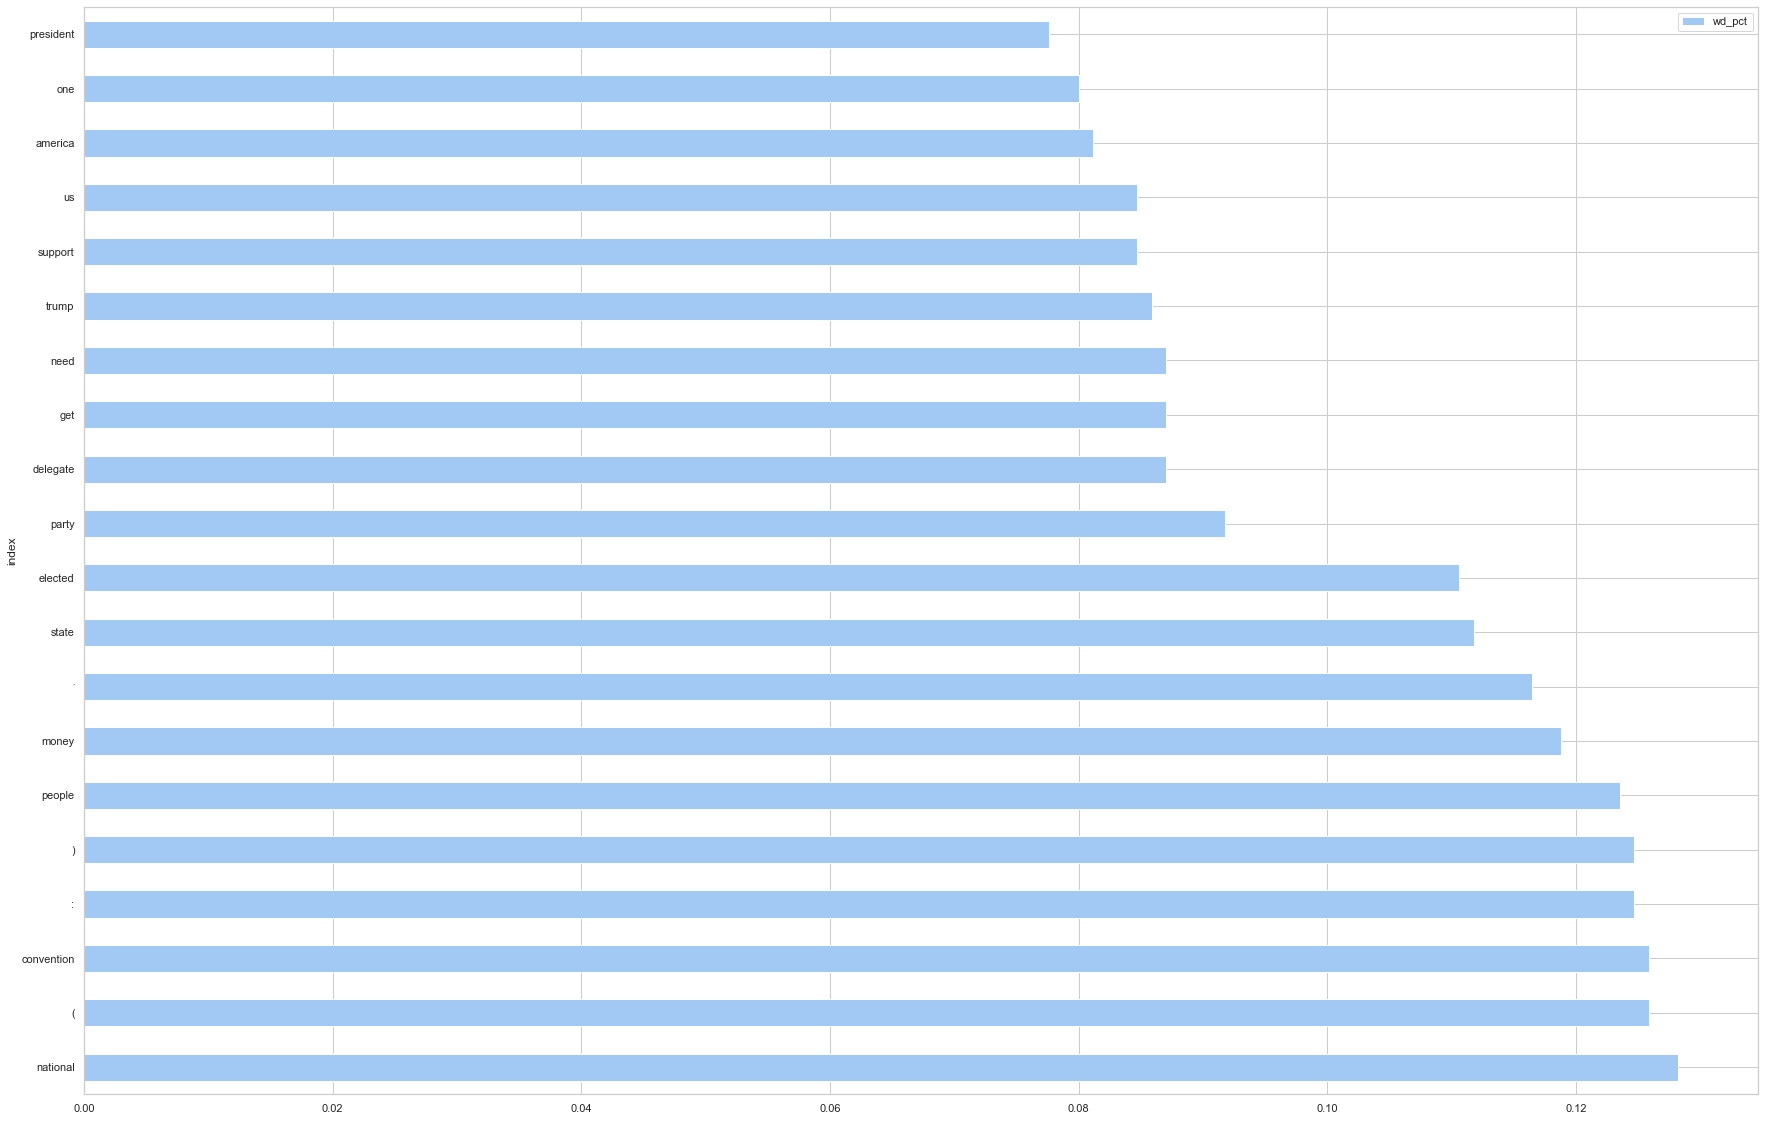

In [258]:
dem_counts.sort_values('wd_pct',ascending=False)[10:30].plot(x='index',y='wd_pct',kind='barh',figsize=(30,20))

All frequencies, including STOPWORDS:
           Word  Frequency
0           the       3333
1             ,       2911
2             .       2664
3            to       2615
4           and       2085
5             a       1711
6             i       1697
7            of       1616
8            in       1399
9           ...       1374
10          for       1102
11           is        964
12           my        706
13           we        646
14         this        546
15            !        540
16           on        519
17          our        499
18         that        496
19         have        491
20           as        467
21          are        458
22           am        412
23           be        409
24         will        406
25          was        376
26         with        370
27          you        360
28           it        335
29           's        323
..          ...        ...
470           '         20
471         car         20
472       white         20
473        stop  

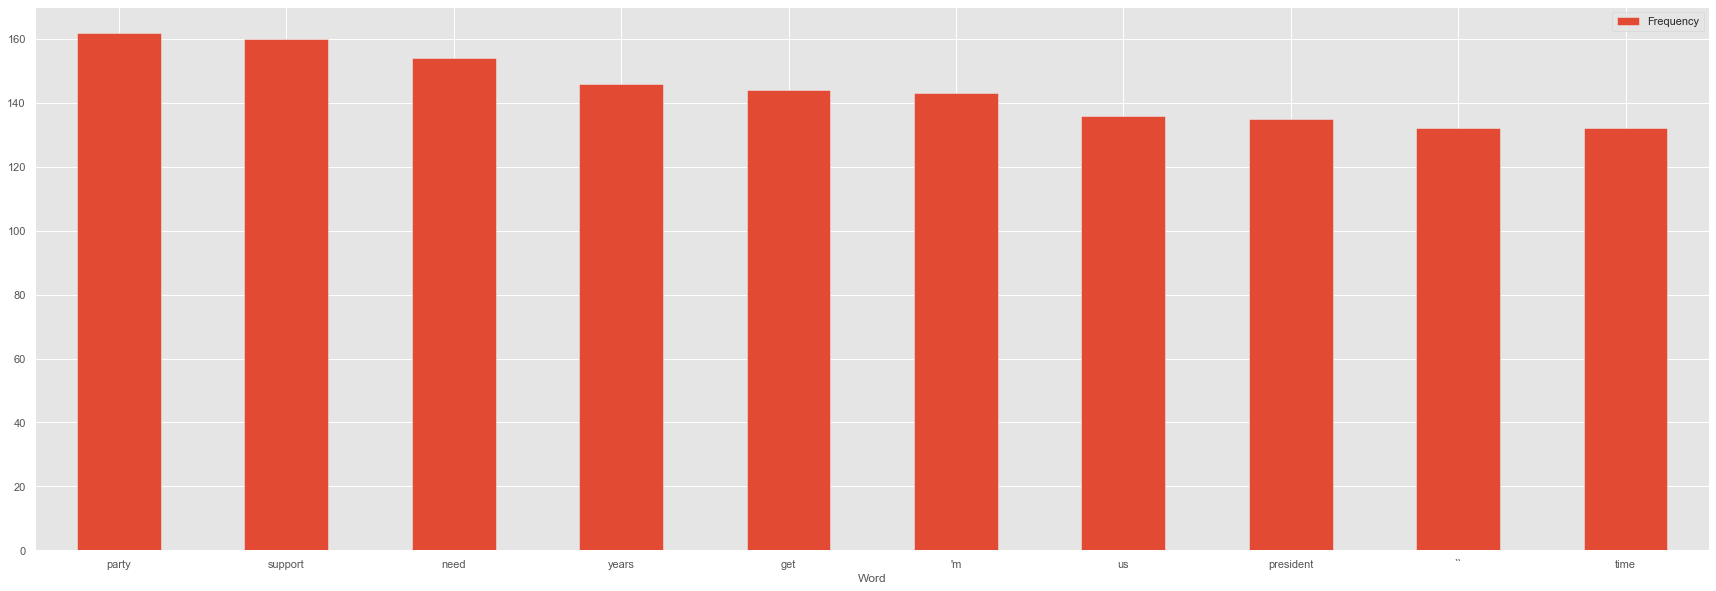

In [21]:
#all words
top_N = 500
txt = df['summary'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
matplotlib.style.use('ggplot')
rslt[20:30].plot.bar(rot=0,figsize=(30,10))

In [261]:
#combinging rep and dem counts dataframs
rep_counts['tag']='rep'
dem_counts['tag']='dem'
words_df=rep_counts.append(dem_counts)
words_df=words_df.reset_index()


/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph

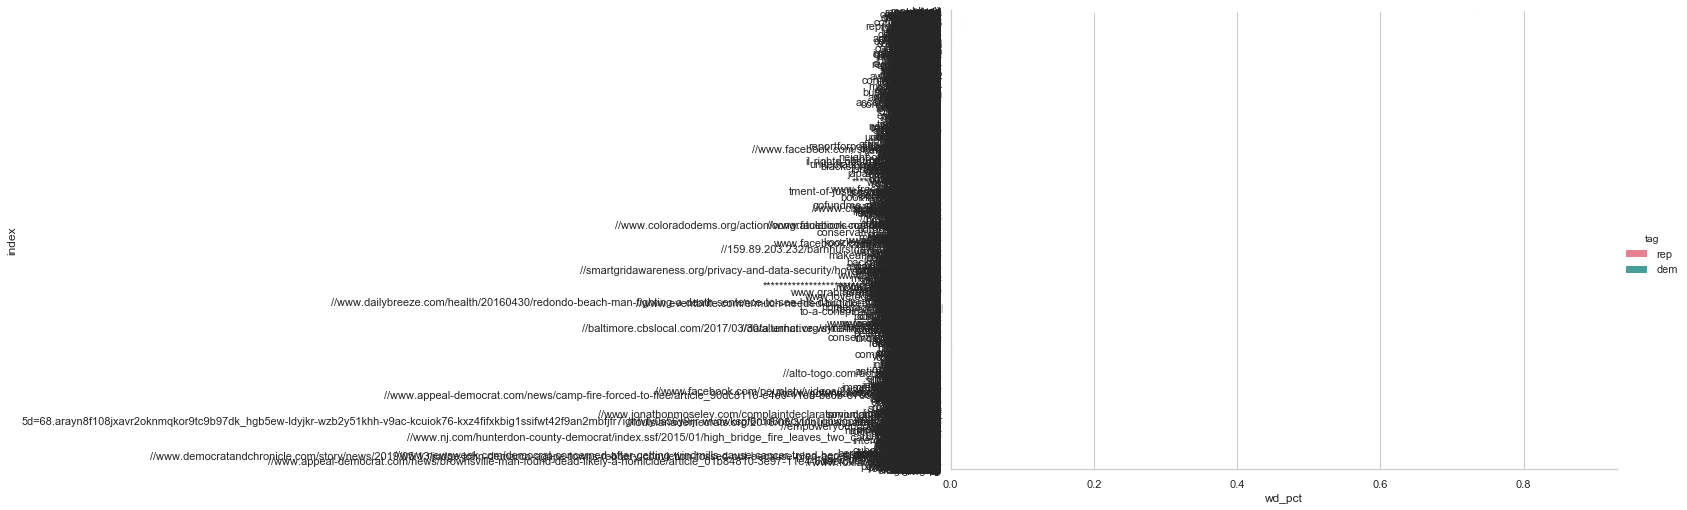

In [268]:
sns.catplot(y="index", x="wd_pct", hue="tag", kind="bar", 
            data=words_df[words_df.index.isin(['.',',','$', '--','-', '?',"'m",'``',"''",';','“','”','nonetype'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [23]:
#ideally, I would bin and graph
rslt=rslt.reset_index()

In [27]:
ser_df=rslt
ser_df=ser_df.rename(columns={'Frequency':'total'})


In [28]:
ser_df.head(3)

,Word,total
0,",",2911
1,.,2664
2,...,1374


In [29]:
words_df=words_df.merge(ser_df,left_on='Word',right_on='Word',how='left')
words_df.head()

,Word,Frequency,tag,wd_pct,total
0,",",1683,rep,0.659741,2911.0
1,.,1571,rep,0.615837,2664.0
2,...,804,rep,0.315171,1374.0
3,!,308,rep,0.120737,540.0
4,republican,273,rep,0.107017,275.0


In [30]:
ser_df[ser_df['Word']=='republican']

,Word,total
6,republican,275


In [31]:
rslt[rslt['Word']=='republican']

,Word,Frequency
6,republican,275


In [32]:
words_df[words_df['Word']=='republican']

,Word,Frequency,tag,wd_pct,total
4,republican,273,rep,0.107017,275.0


In [33]:
ser=words_df.total

In [40]:
words_df['word_bin']=pd.qcut(ser, q=5,labels=['1','2','3','4','5'])

# sns.catplot(kind='bar',x='Frequency',y='Word',hue='tag',row='word_bin',data=words_df,height=20,aspect=2)

In [51]:
#making individual bins because 
words_df_3=words_df[words_df['word_bin']=='3']
words_df_1=words_df[words_df['word_bin']=='1']
words_df_2=words_df[words_df['word_bin']=='2']
words_df_4=words_df[words_df['word_bin']=='4']
words_df_5=words_df[words_df['word_bin']=='5']

In [42]:
words_df_3.Word.unique()

array(['nonetype', 'congress', 'start', '”', 'right', 'raised',
       'presidential', 'story', 'left', 'come', 'governor', 'club', 'ago',
       '#', 'small', 'way', 'long', 'change', 'together', 'week', 'keep',
       'used', 'good', 'group', 'care', 'education', 'city', 'show',
       'media', 'important', 'former', 'around', 'build', 'trying',
       'must', 'law', 'issues', 'fellow', 'bring', 'november', 'friend',
       'continue', 'dear', 'read', '5', 'helping', 'today', 'june',
       'future', 'past', 'voters', 'still', 'part', 'little', 'put',
       'news', 'become', 'cover', 'travel', 'funding', 'lives', 'strong',
       'member', '4', 'ca', 'voting', 'nation', 'page', 'march',
       'facebook', 'liberal', 'ever', 'lost', 'expenses', 'senator',
       'hard', 'away', 'provide', 'getting', 'world', 'send', 'cost',
       'delegates', 'hillary', 'dnc', 'progressive', 'honor', 'upcoming',
       'san'], dtype=object)

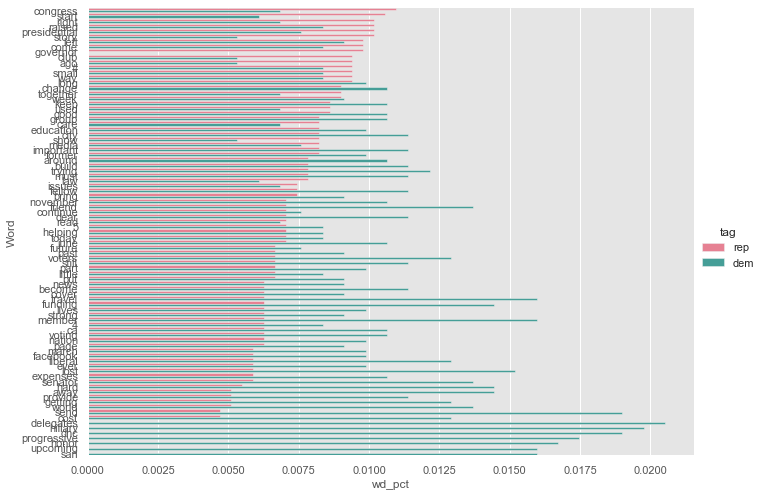

In [48]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_3[words_df_3.Word.isin(['$', '--','-', '?',"'m",'``',"''",';','“','”','nonetype'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [52]:
words_df_5.Word.unique()

array([',', '.', '...', '!', 'republican', "'s", '’', ':', 'help', '(',
       ')', 'trump', 'republicans', 'people', 'money', 'support', 'state',
       'years', 'party', '``', 'name', "''", 'campaign', "'m", 'need',
       'political', 'time', 'president', 'get', 'want', 'family', 'like',
       'would', 'us', '-', '?', 'one', 'many', 'new', 'america',
       'national', 'year', 'college', 'make', 'country', 'county', '$',
       '--', 'school', 'conservative', 'american', 'states', 'democratic',
       'united', 'election', 'please', 'first', 'democrat', 'life', 'go',
       'know', 'running', 'elected', 'great', 'democrats', 'vote', "n't",
       'community', 'raise', 'hello', 'funds', 'hi', 'convention',
       'raising', 'district', 'friends', 'work', 'since', 'young', 'fund',
       'house', 'high', 'delegate', '2016', 'bernie', 'sanders'],
      dtype=object)

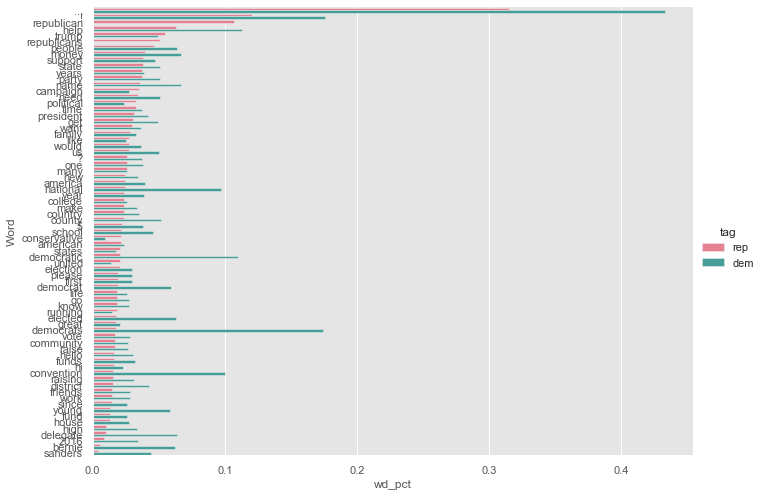

In [54]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_5[words_df_5.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';','(',')',"n't",'--','-'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

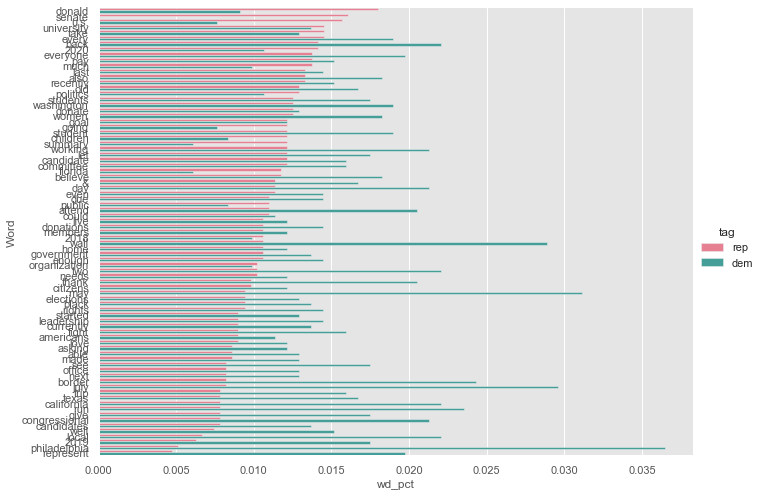

In [50]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_4[words_df_4.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [182]:
ser 